In [1]:
%pylab inline

# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install bioread

from IPython.display import Markdown, display
import bioread
import os
import pandas as pd
import numpy as np
pylab.rcParams['figure.figsize'] = (20.0, 6.0)
from scipy.signal import butter, lfilter, resample, periodogram

None

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (20.0, 6.0)

In [3]:
def get_sublist(subDir):
    """ Lists all directories in a main directories of all subjects to create a subject list. Note that this is BIDS format specific (assumes all subject directories begin "sub-xxx". Could be modified.
 Return: subject list """
    sublist = []
    for subnum in np.sort(os.listdir(subDir)): 
        if len(subnum) == 3: 
            if not 'html' in subnum: 
                sublist.append(subnum) 
    return sublist

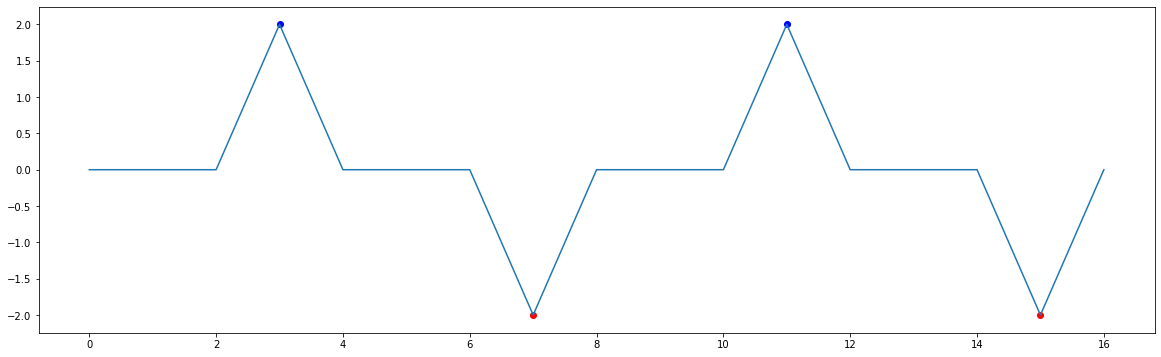

In [4]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

if __name__=="__main__":
    from matplotlib.pyplot import plot, scatter, show
    series = [0,0,0,2,0,0,0,-2,0,0,0,2,0,0,0,-2,0]
    maxtab, mintab = peakdet(series,.3)
    plot(series)
    scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
    scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
    show()

In [5]:
physPath = '/Users/Eichenbaum/HWNI/Experiments/nScout/data/physio'

sublist = get_sublist(physPath)

# Determine how long the scan should be
TR = 1.5 #seconds
nVols = 400 # number of TRs collected
sampRate = 125 # Samples per second
nSamplesRun = int(TR * nVols * sampRate)

In [6]:
# This is going to be a loop that takes in the raw physio data, isolates each epi run, 
# standardizes the run (scales value to be between 0 - 1), and then bandpass filters it
sublist = ['087']
for sidx, sub in enumerate(sublist):
    
    subpath = '%s/%s' %(physPath, sub)
    fname = os.listdir('%s/%s/' %(physPath, sub))[0]
    fullpath = '%s/%s' %(subpath, fname)
    
#     print(fullpath)
    data = bioread.read_file('%s' %(fullpath))
    
    HR_arr = np.ones((nSamplesRun, 2))
    BR_arr = np.ones((nSamplesRun, 2))
    
    HR_arr_scl = np.ones((nSamplesRun, 2))
    BR_arr_scl = np.ones((nSamplesRun, 2))
    
    filtered_xHR = np.ones((nSamplesRun, 2))
    filtered_xBR = np.ones((nSamplesRun, 2))
        
    HR_chan = data.channels[0]
    BR_chan = data.channels[2]
    TTL_chan = data.channels[3]

    # Find the time point when the very first TTL signal comes in (usually 8 ± 1 in duration of 1 TTL)
    TTL_startR1 = np.where(TTL_chan.data>4)[0][0]

    # Isolate all the data that occurs AFTER Run 1 ends
    run2_TTL_data_pre = TTL_chan.data[TTL_startR1 + nSamplesRun:]
   
    # Now determine when the first TTL comes in in this new chunk
    TTL_startR2 = np.where(run2_TTL_data_pre>4)[0][0]

    # The chunk of data for Run 1 (of 2) should be the first TTL sample + nSamplesRun [75000]
    run1_HR_data = HR_chan.data[TTL_startR1:TTL_startR1 + nSamplesRun]
    run1_HR_time = HR_chan.time_index[TTL_startR1:TTL_startR1 + nSamplesRun]

    run1_BR_data = BR_chan.data[TTL_startR1:TTL_startR1 + nSamplesRun]
    run1_BR_time = BR_chan.time_index[TTL_startR1:TTL_startR1 + nSamplesRun]

    # First step will be to isolate all the data that occurs AFTER Run 1's chunk ends
    run2_HR_data_pre = HR_chan.data[TTL_startR1 + nSamplesRun:]
    run2_HR_time_pre = HR_chan.time_index[TTL_startR1 + nSamplesRun:]

    run2_BR_data_pre = BR_chan.data[TTL_startR1 + nSamplesRun:]
    run2_BR_time_pre = BR_chan.time_index[TTL_startR1 + nSamplesRun:]

    # Isolate the run the 10 minutes that occur after the first TTL pulse
    run2_HR_data = run2_HR_data_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
    run2_HR_time = run2_HR_time_pre[TTL_startR2:TTL_startR2 + nSamplesRun]

    run2_BR_data = run2_BR_data_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
    run2_BR_time = run2_BR_time_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
    
    HR_arr = np.hstack((run1_HR_data[:,np.newaxis], run2_HR_data[:,np.newaxis]))
    BR_arr = np.hstack((run1_BR_data[:,np.newaxis], run2_BR_data[:,np.newaxis]))
    
    ### With the data isolated, now we need to standardize the raw, isolated traces
    for run in [0,1]:
        print(run)
        xMinHR = np.min(HR_arr[:,run])
        xMaxHR = np.max(HR_arr[:,run])

        xMinBR = np.min(BR_arr[:,run])
        xMaxBR = np.max(BR_arr[:,run])

        newDataHR = [ [np.divide([x-xMinHR], [xMaxHR - xMinHR])] for x in HR_arr[:,run]]
        HR_arr_scl[:,run] = np.squeeze(newDataHR)
        
        newDataBR = [ [np.divide([x-xMinBR], [xMaxBR - xMinBR])] for x in BR_arr[:,run]]
        BR_arr_scl[:,run] = np.squeeze(newDataBR)
        
        ### Filter the data ###

        # Breathing Rate #
        freqLow_BR = 0.25
        freqHigh_BR = 0.50
        windowBR = np.divide([freqLow_BR, freqHigh_BR], sampRate)
        bBR, aBR = butter(1, windowBR, 'bandpass')
        xBR = BR_arr_scl[:,run]
        filtered_xBR[:,run] = lfilter(bBR, aBR, xBR)
        
        # Heart Rate #
        freqLow_HR = 1
        freqHigh_HR = 6
        windowHR = np.divide([freqLow_HR, freqHigh_HR], sampRate)
        bHR,aHR = butter(1, windowHR, 'bandpass')
        xHR = HR_arr_scl[:,run]
        filtered_xHR[:,run] = lfilter(bHR, aHR, xHR)

0
1


# BREATHING RATE -- Run 1

# Raw TimeSeries

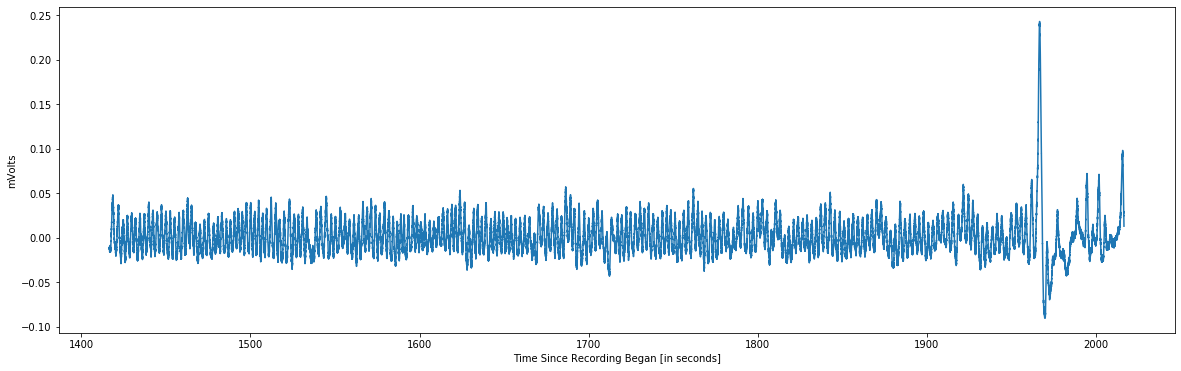

# Standardized TimeSeries

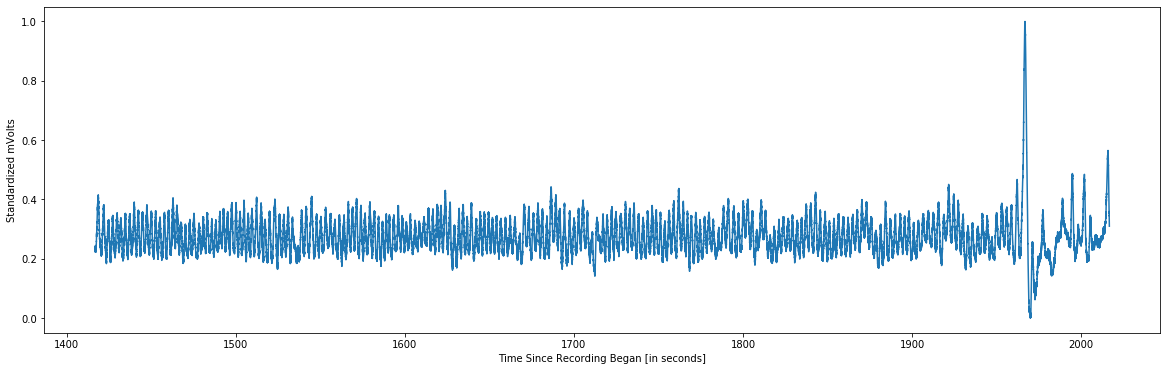

# Filtered TimeSeries

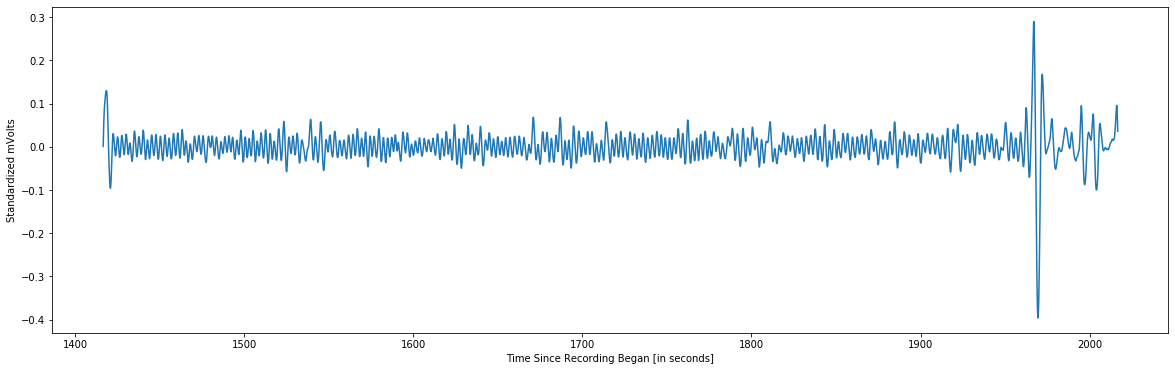

# 100-second chunks

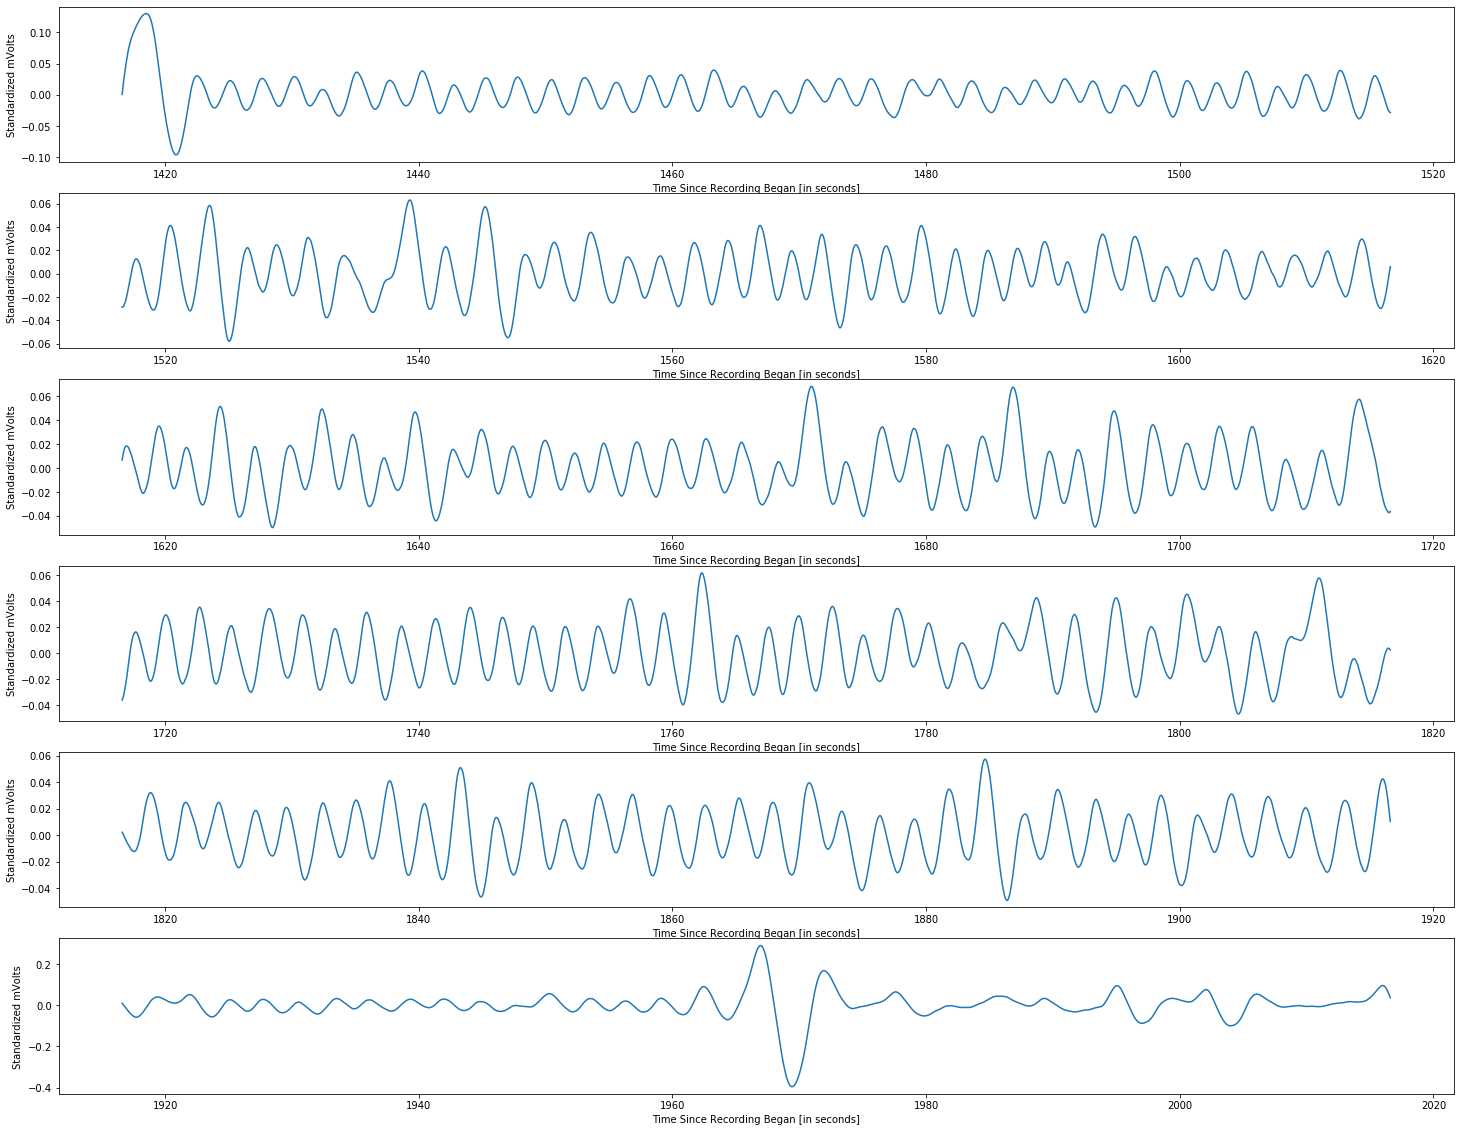

# Power Plot

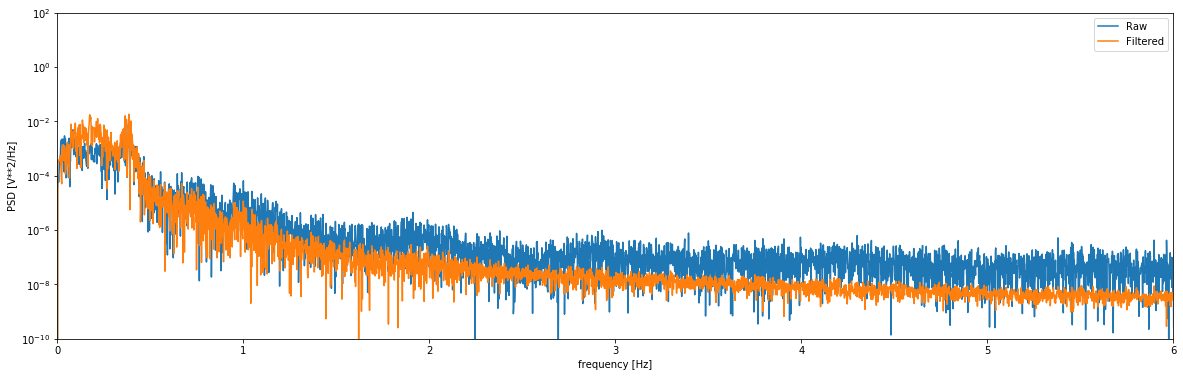

# HEART RATE -- Run 1

# Raw TimeSeries

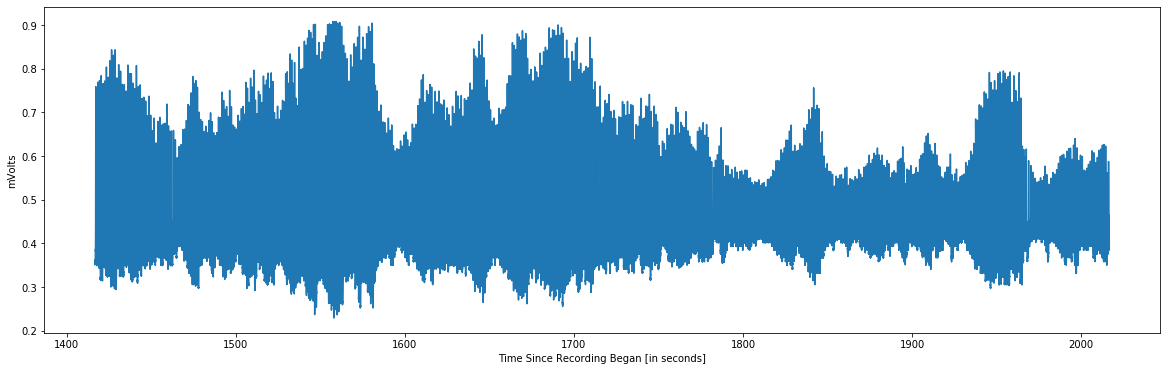

# Standardized TimeSeries

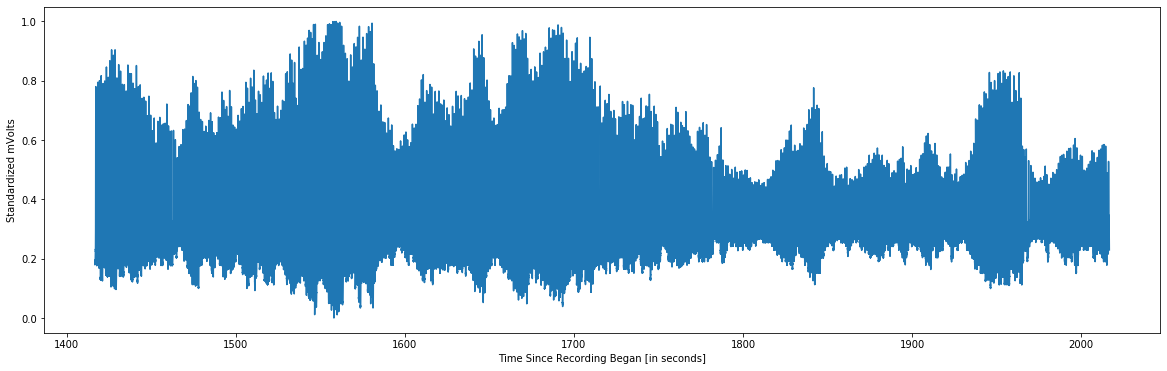

# Filtered TimeSeries

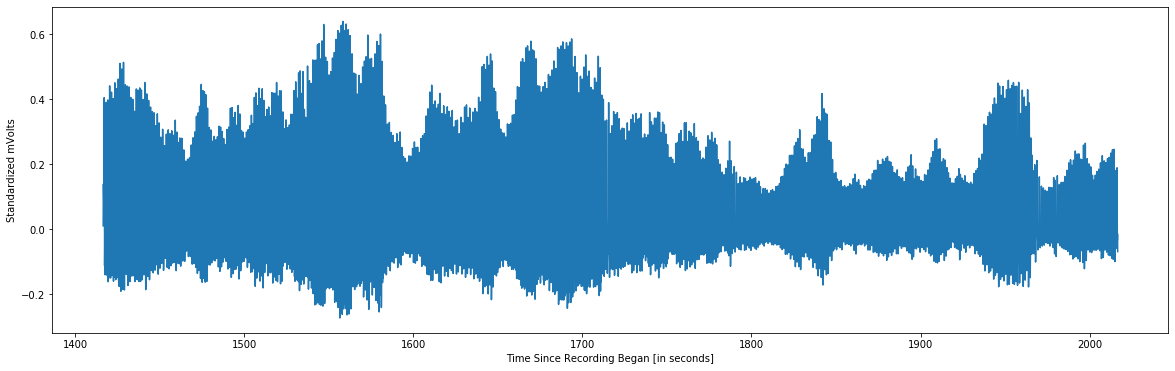

# 50-second chunks

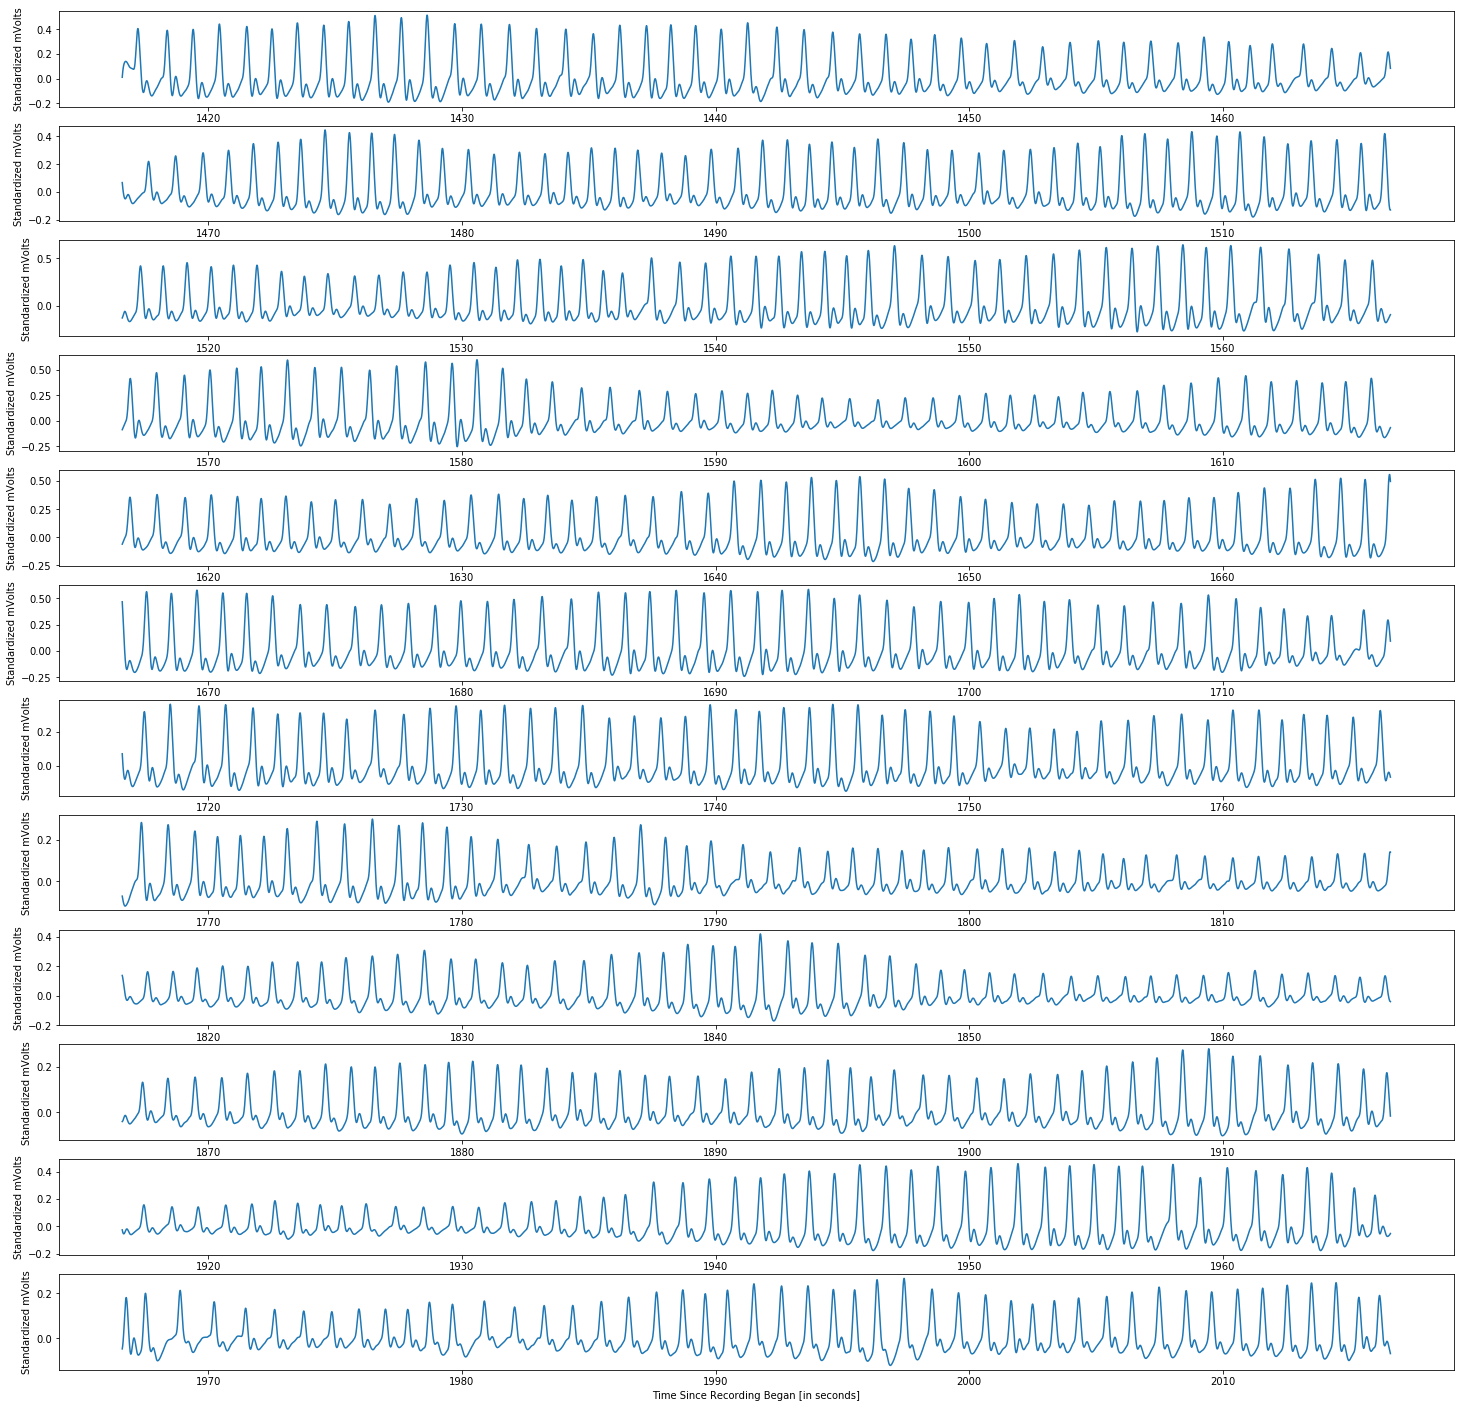

# Power Plot

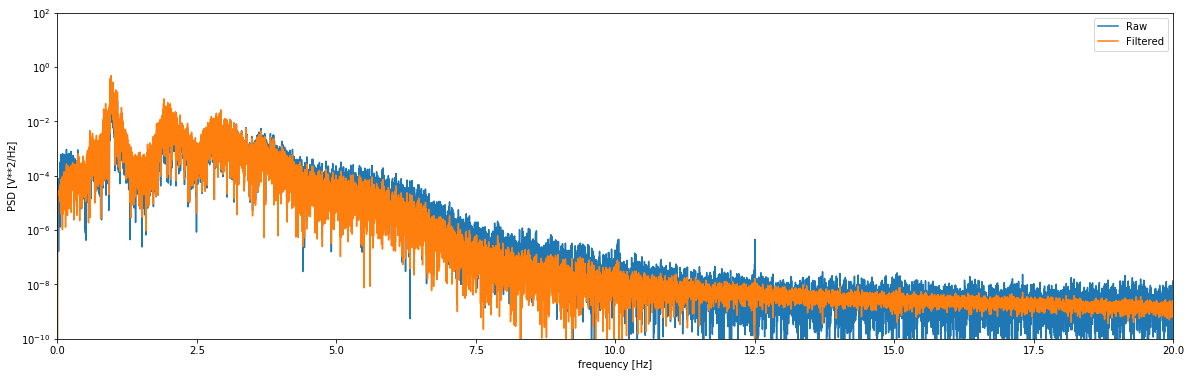

# BREATHING RATE -- Run 2

# Raw TimeSeries

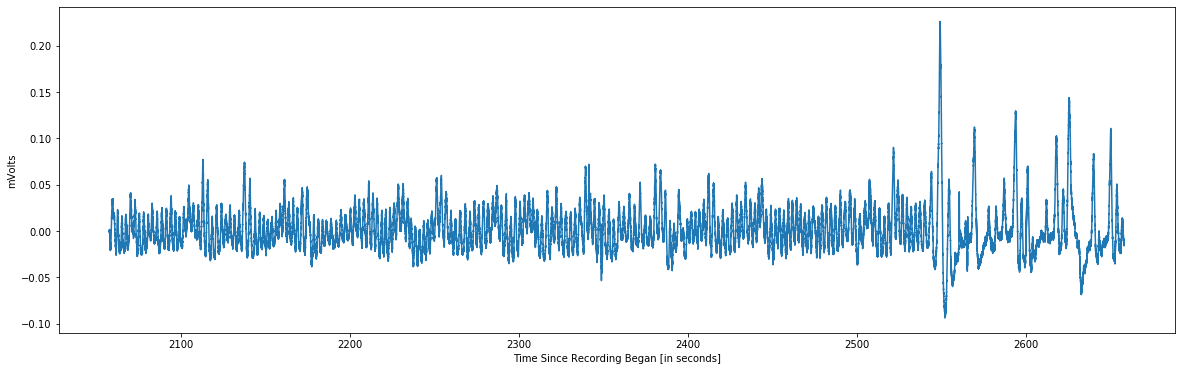

# Standardized TimeSeries

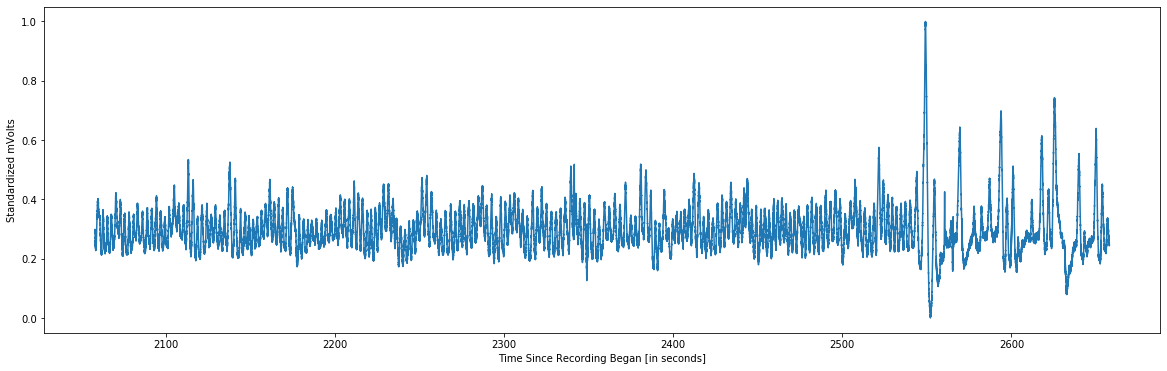

# Filtered TimeSeries

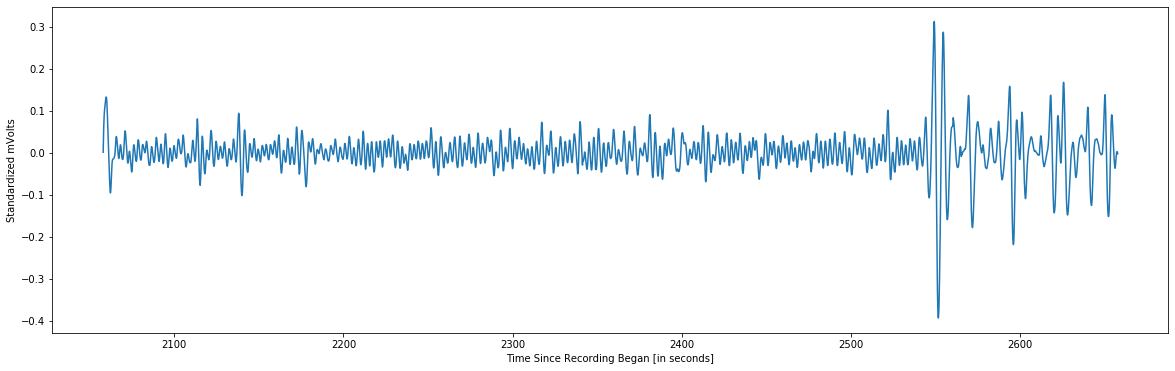

# 100-second chunks

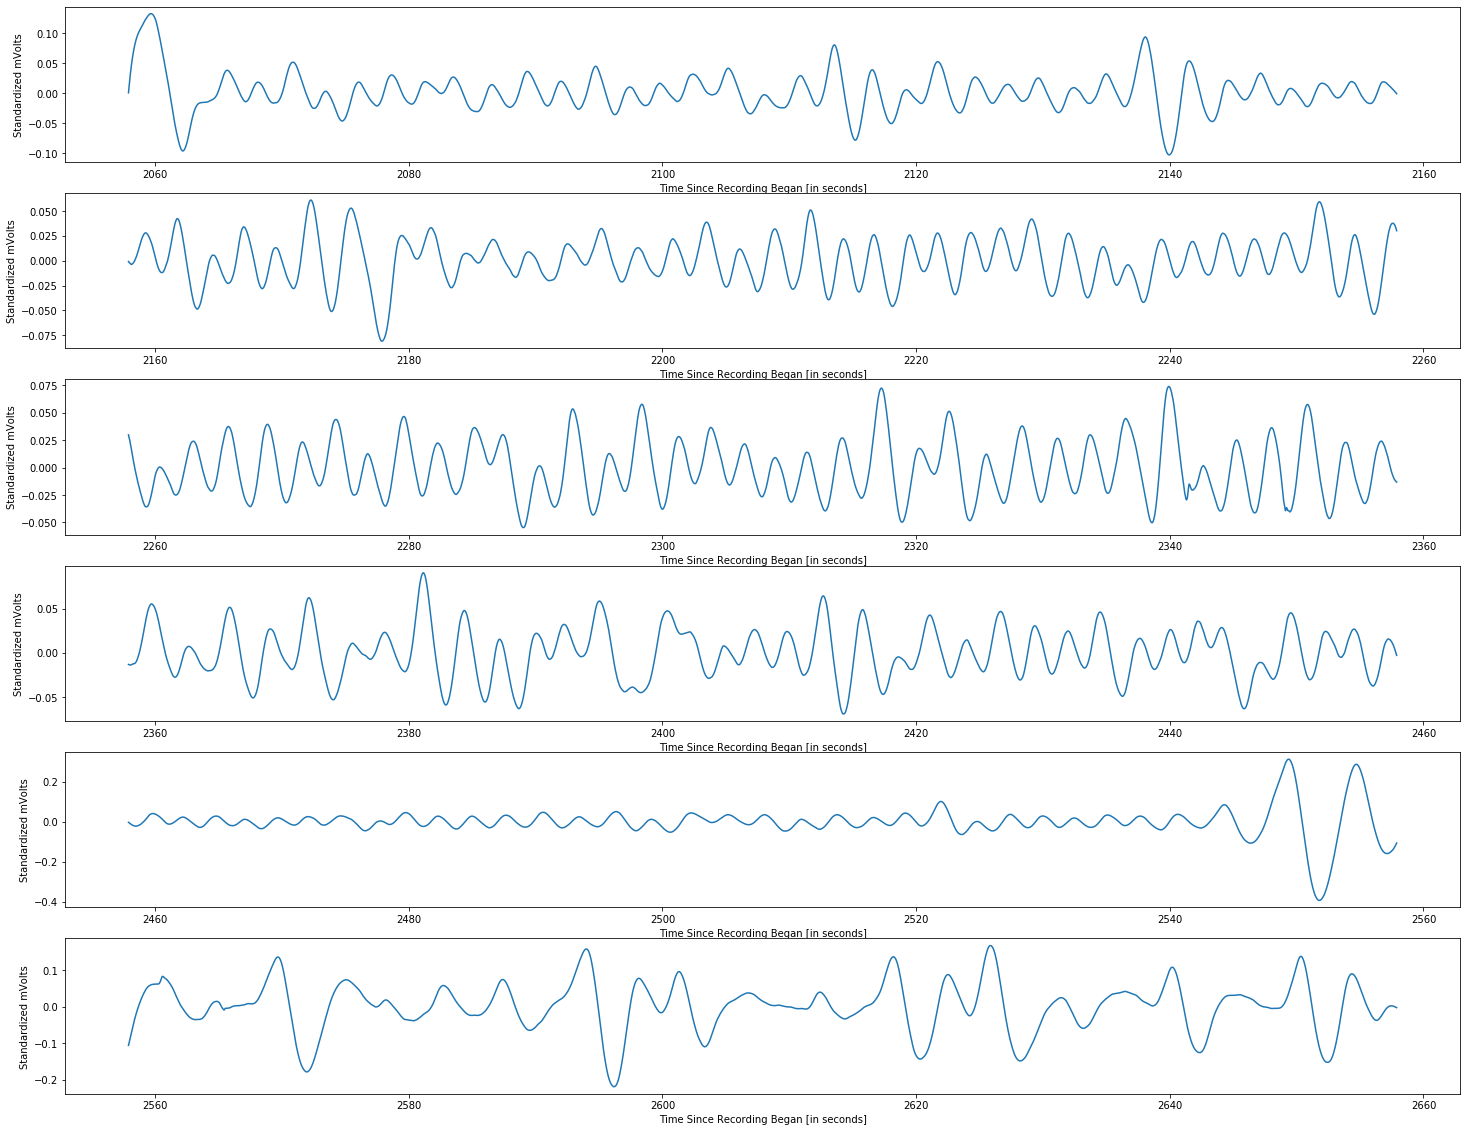

# Power Plot

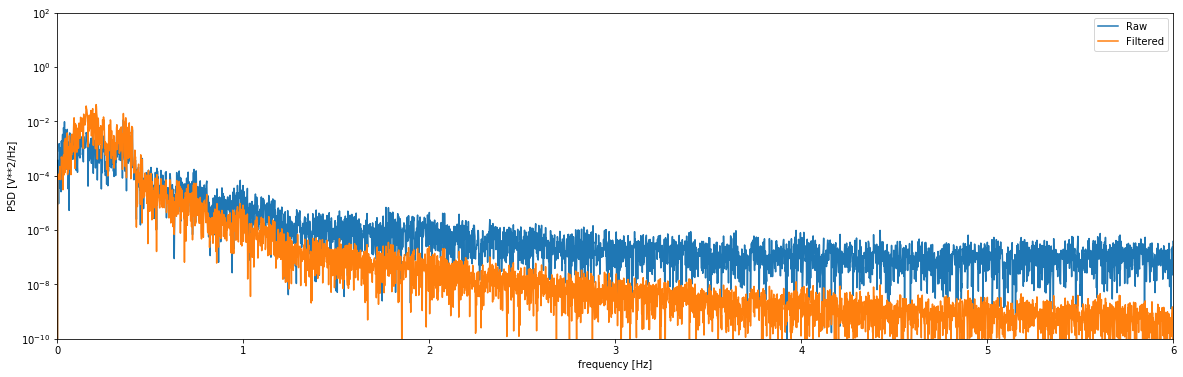

# HEART RATE -- Run 2

# Raw TimeSeries

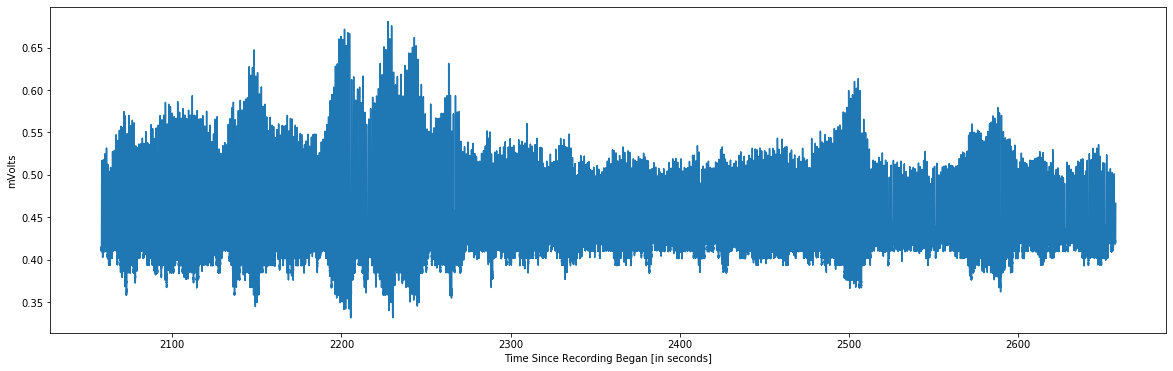

# Standardized TimeSeries

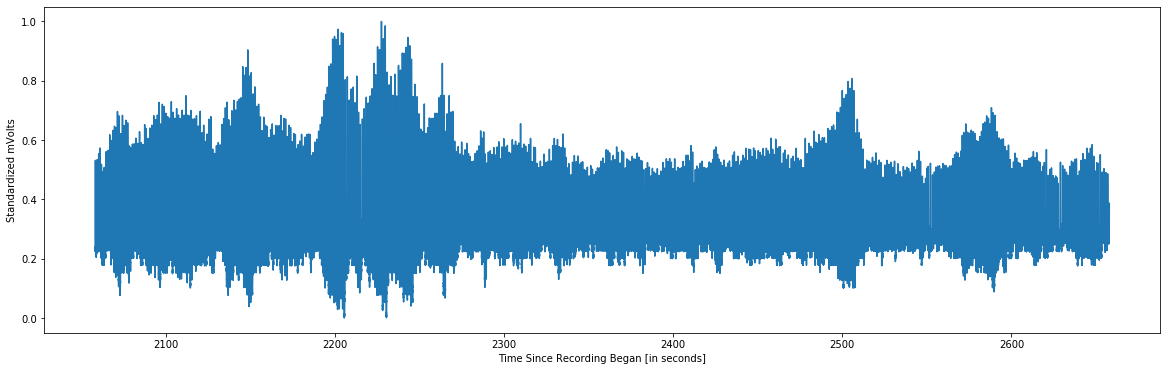

# Filtered TimeSeries

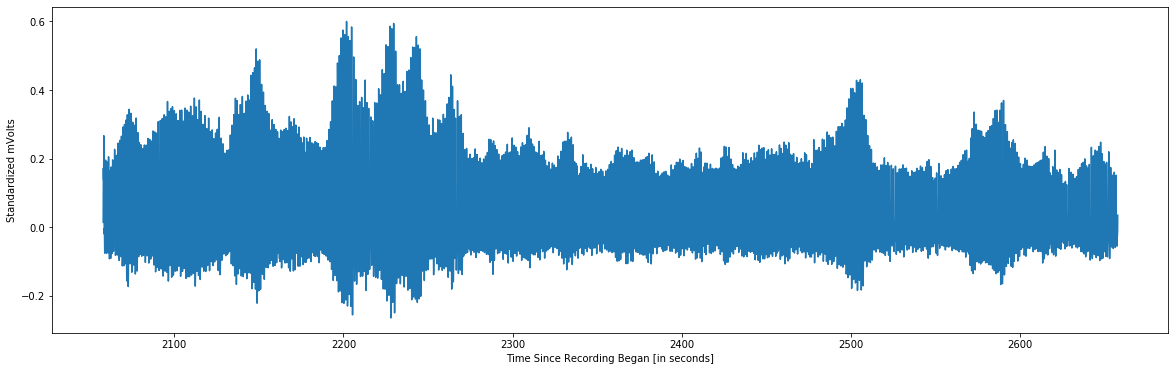

# 50-second chunks

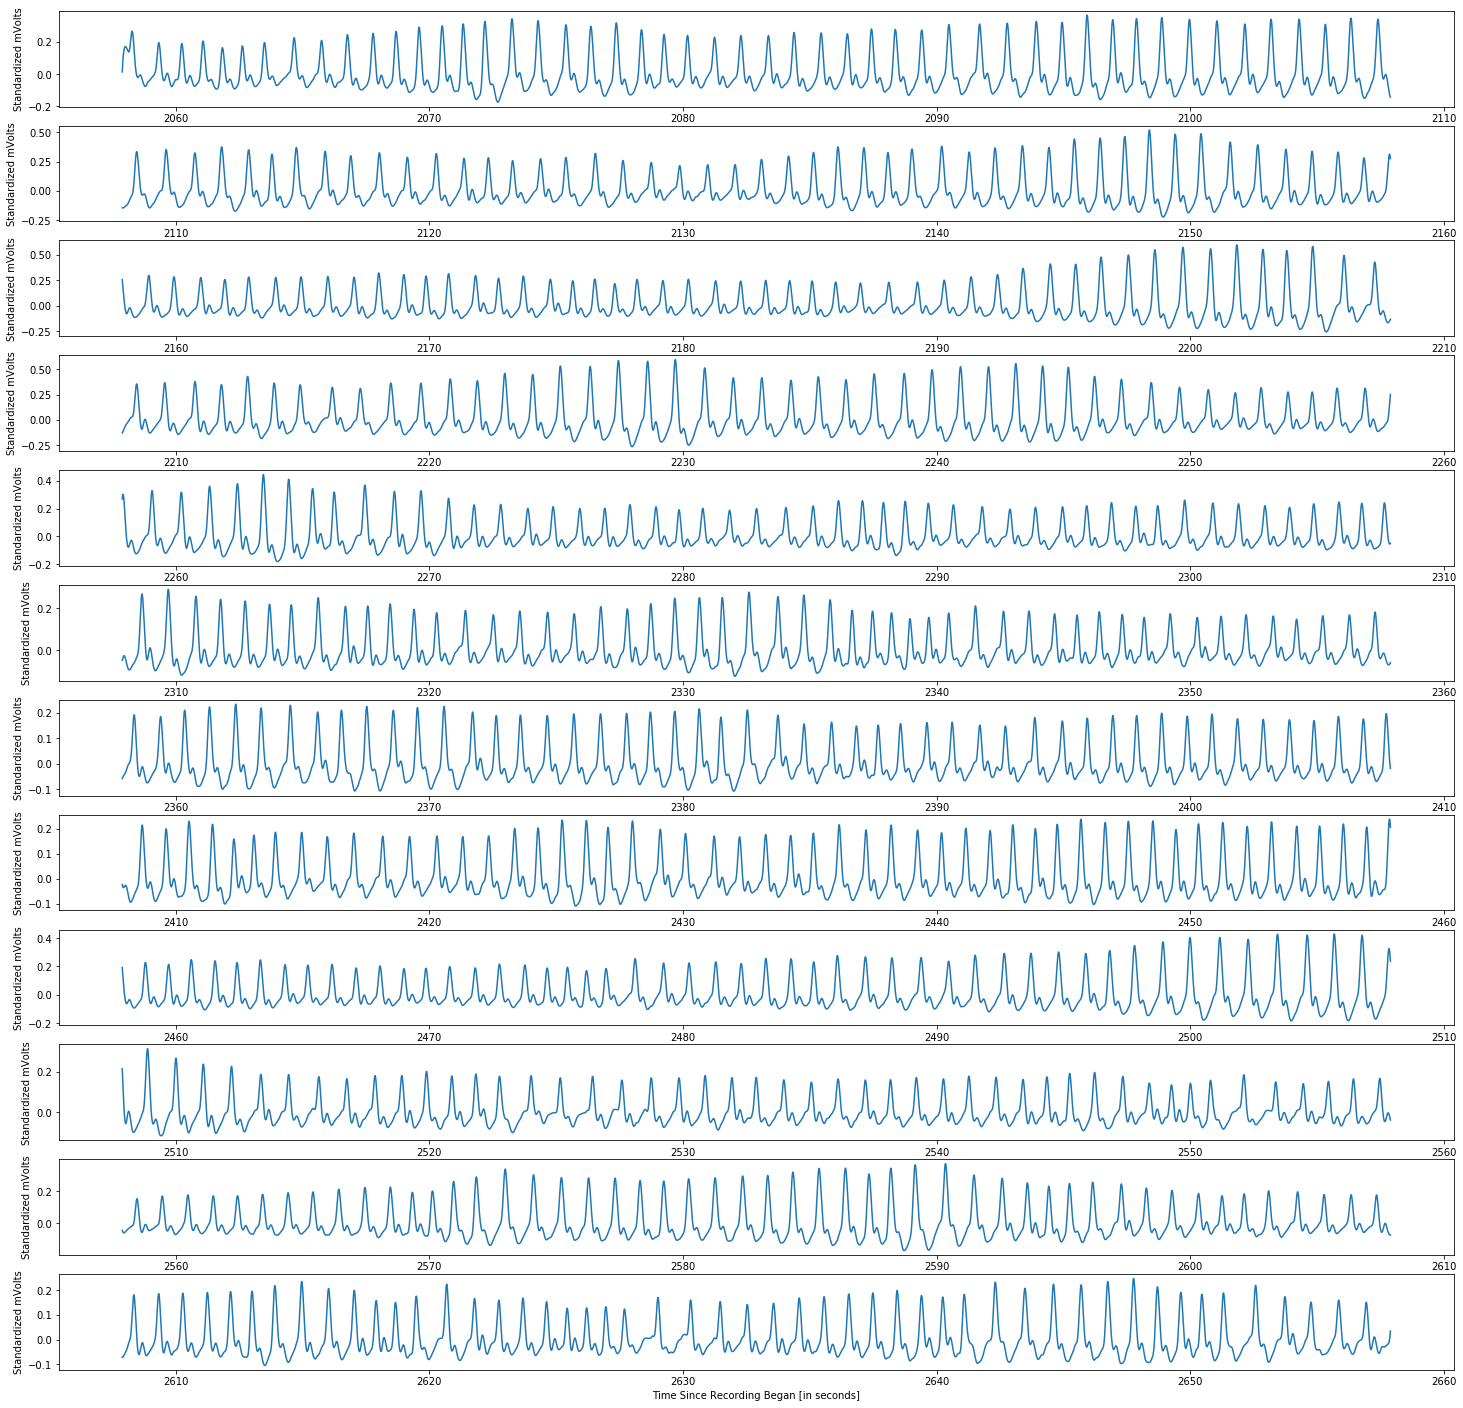

# Power Plot

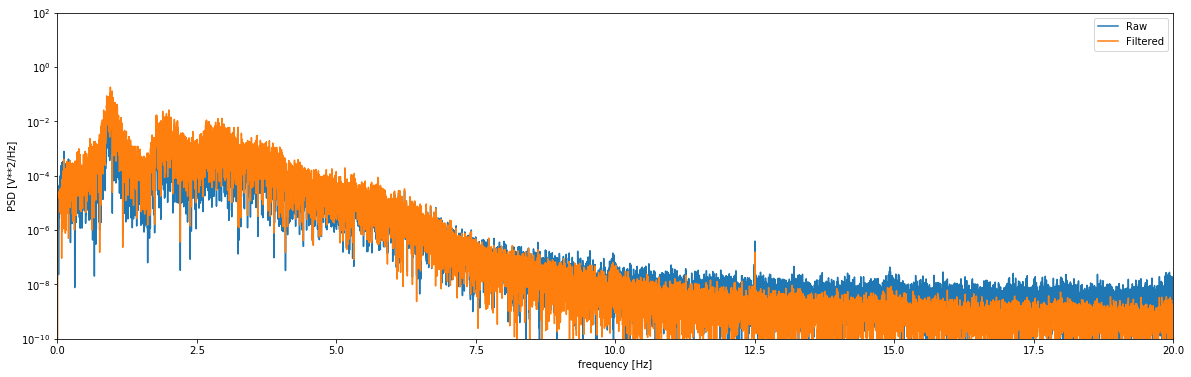

In [7]:
for run in [0,1]:
    if run == 0: 
        time = run1_BR_time #Doesn't matter if BR or HR time. It's the same thing
    else:
        time = run2_BR_time

    ### Plotting ###

    ######################
    ### BREATHING RATE ###
    ######################
    display(Markdown('# BREATHING RATE -- Run %s' %(str(run+1))))
    
    # Raw TimeSeries (all data)
    display(Markdown('# Raw TimeSeries'))
    plt.plot(time, BR_arr[:,run])
    plt.ylabel('mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.savefig('%s/BreathingRate_RawTS_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/BreathingRate_RawTS_run-00%s.txt' %(subpath, str(run+1)), BR_arr[:,run], fmt='%1.9f')
    plt.show()

    # Standardized TimeSeries
    display(Markdown('# Standardized TimeSeries'))
    plt.plot(time, BR_arr_scl[:,run])
    plt.ylabel('Standardized mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.show()

    # Filtered TimeSeries
    display(Markdown('# Filtered TimeSeries'))
    plt.plot(time, filtered_xBR[:,run])
    plt.ylabel('Standardized mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.savefig('%s/BreathingRate_FilteredTS_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/BreathingRate_FilteredTS_run-00%s.txt' %(subpath, str(run+1)), filtered_xBR[:,run], fmt='%1.9f') 
    plt.show()

    # 100 second chunks of filtered timeseries
    f, axs = plt.subplots(6, 1, figsize=(25,20))
    display(Markdown('# 100-second chunks'))
    spaces = np.linspace(0,75000,7)
    for chunk in range(6):
        indexA = int(spaces[chunk])
        indexB = int(spaces[chunk + 1])
        axs[chunk].plot(time[indexA:indexB], filtered_xBR[indexA:indexB, run])
        axs[chunk].set_ylabel('Standardized mVolts')
        axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
    plt.show()

    # Power Spectrum Plot (Raw vs. Filtered)
    display(Markdown('# Power Plot'))
    f, Pxx_den = periodogram(BR_arr[:,run], 125)
    fFilt, Pxx_denFilt = periodogram(filtered_xBR[:,run], 125)
    plt.semilogy(f, Pxx_den)
    plt.semilogy(fFilt, Pxx_denFilt)
    plt.ylim([1e-10, 1e2])
    plt.xlim([0,6])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(['Raw', 'Filtered'])
    plt.savefig('%s/BreathingRate_PowerPlot_run-00%s.pdf' %(subpath, str(run+1)))
    plt.show()
    
    
    
    ######################
    ### Heart RATE ###
    ######################
    
    display(Markdown('# HEART RATE -- Run %s' %(str(run+1))))
    
    # Raw TimeSeries (all data)
    display(Markdown('# Raw TimeSeries'))
    plt.plot(time, HR_arr[:,run])
    plt.ylabel('mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.savefig('%s/HeartRate_RawTS_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/HeartRate_RawTS_run-00%s.txt' %(subpath, str(run+1)), HR_arr[:,run], fmt='%1.9f')
    plt.show()

    # Standardized TimeSeries
    display(Markdown('# Standardized TimeSeries'))
    plt.plot(time, HR_arr_scl[:,run])
    plt.ylabel('Standardized mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.show()

    # Filtered TimeSeries
    display(Markdown('# Filtered TimeSeries'))
    plt.plot(time, filtered_xHR[:,run])
    plt.ylabel('Standardized mVolts')
    plt.xlabel('Time Since Recording Began [in seconds]')
    plt.savefig('%s/HeartRate_FilteredTS_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/HeartRate_FilteredTS_run-00%s.txt' %(subpath, str(run+1)), filtered_xHR[:,run], fmt='%1.9f') 
    plt.show()

    # 100 second chunks of filtered timeseries
    f, axs = plt.subplots(12, 1, figsize=(25,25))
    display(Markdown('# 50-second chunks'))
    spaces = np.linspace(0,75000,13)
    for chunk in range(12):
        indexA = int(spaces[chunk])
        indexB = int(spaces[chunk + 1])
        axs[chunk].plot(time[indexA:indexB], filtered_xHR[indexA:indexB, run])
        axs[chunk].set_ylabel('Standardized mVolts')
        axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
    plt.show()

    # Power Spectrum Plot (Raw vs. Filtered)
    display(Markdown('# Power Plot'))
    f, Pxx_den = periodogram(HR_arr[:,run], 125)
    fFilt, Pxx_denFilt = periodogram(filtered_xHR[:,run], 125)
    plt.semilogy(f, Pxx_den)
    plt.semilogy(fFilt, Pxx_denFilt)
    plt.ylim([1e-10, 1e2])
    plt.xlim([0,20])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(['Raw', 'Filtered'])
    plt.savefig('%s/HeartRate_PowerPlot_run-00%s.pdf' %(subpath, str(run+1)))
    plt.show()

# BREATHING RATE -- Run 1

# 100-second chunks

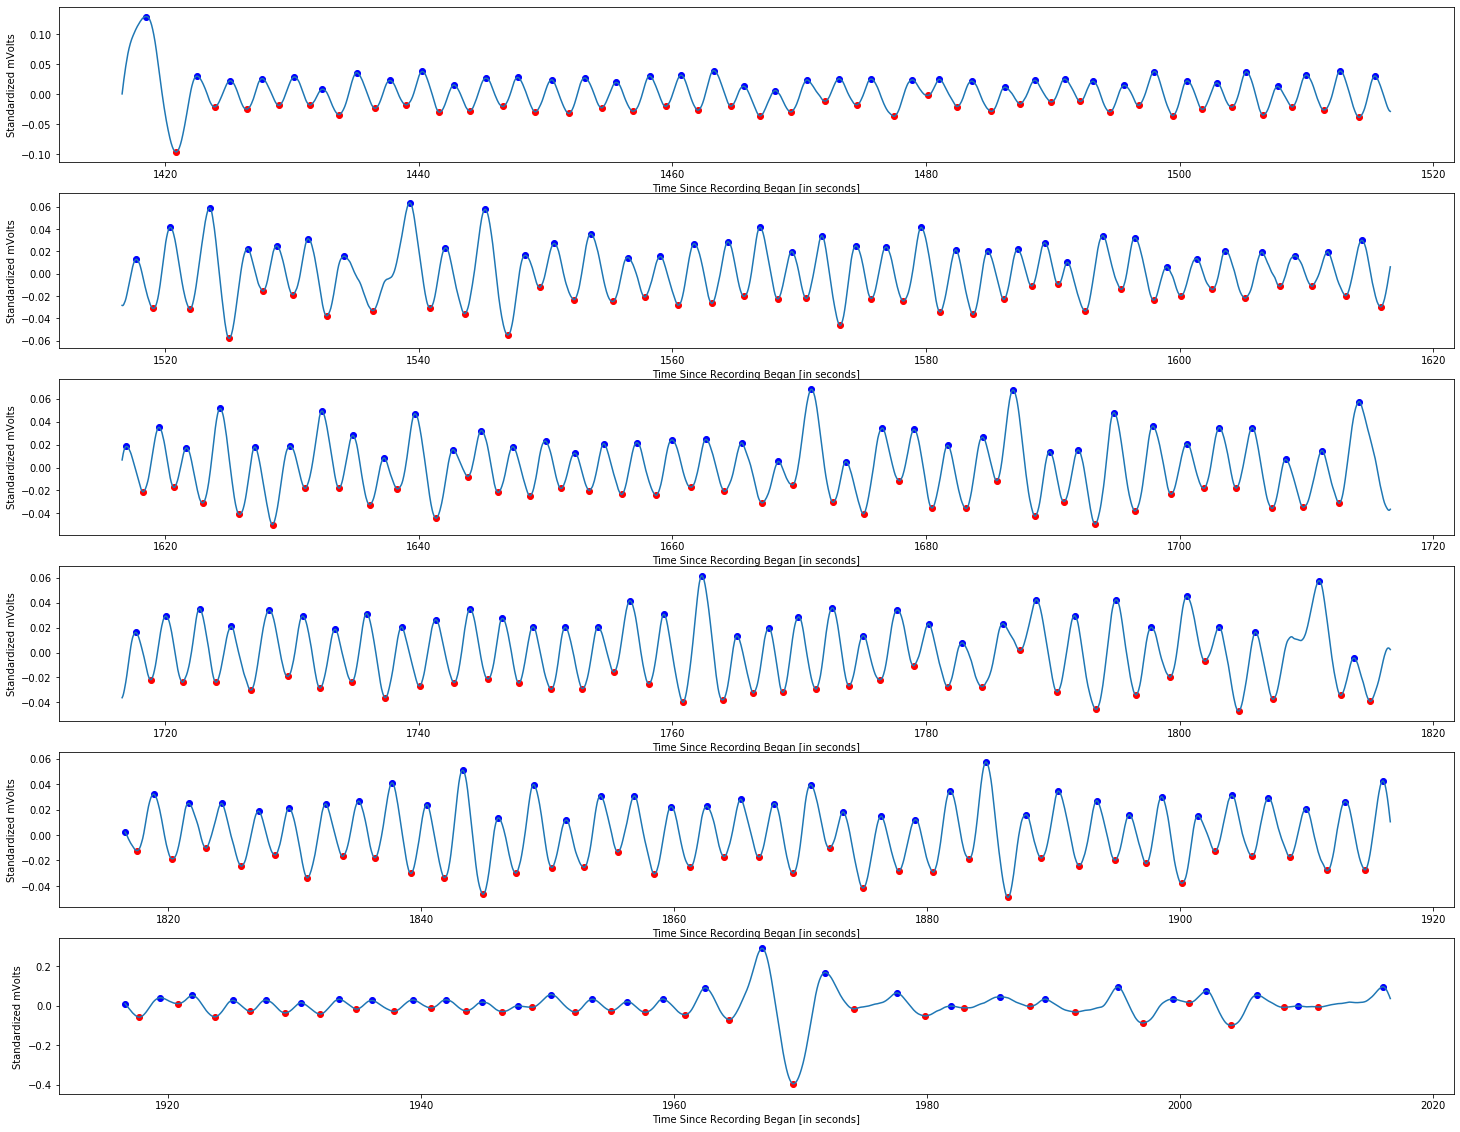

Full Run =  (215,)    Summed chunks =  (216,)


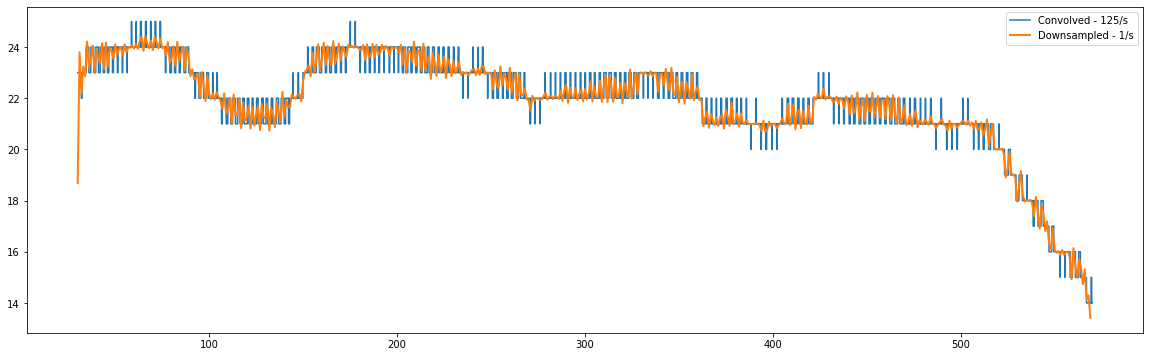

# HEART RATE -- Run 1

# 50-second chunks

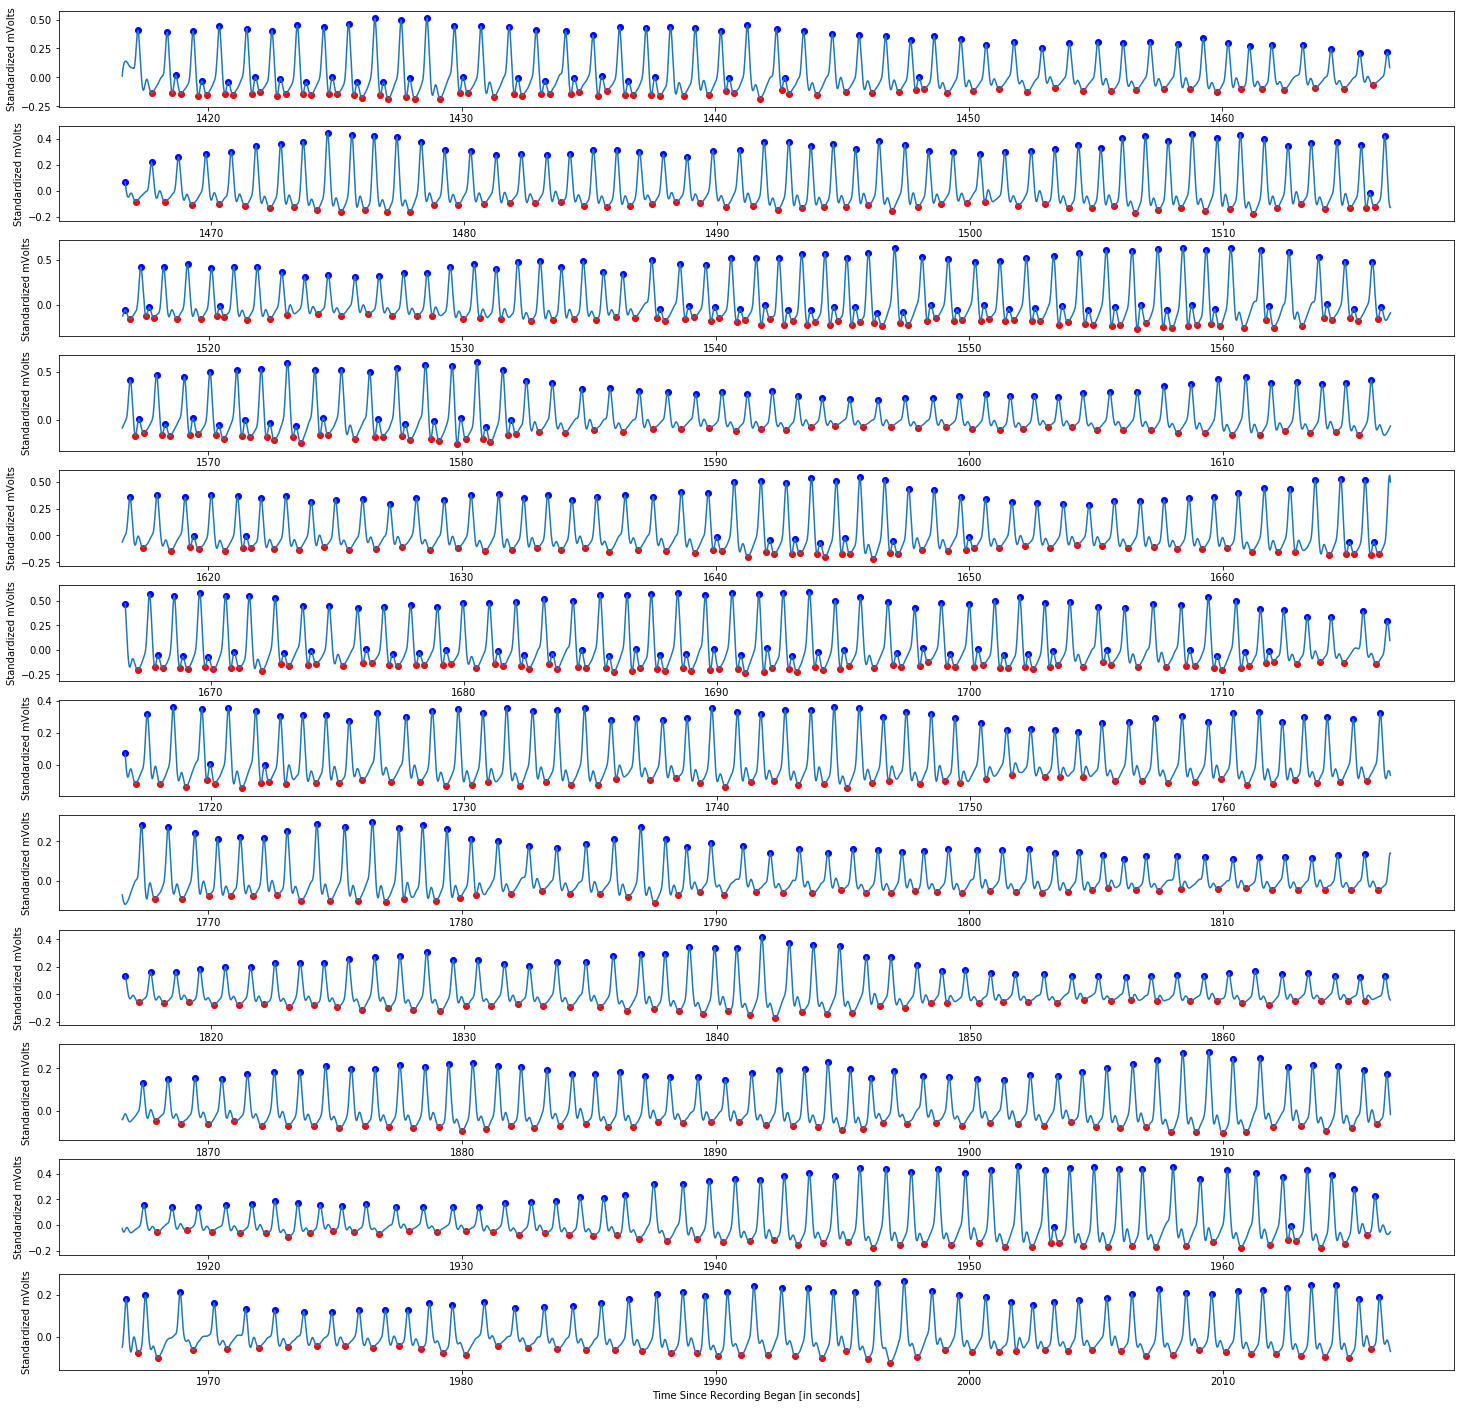

Full Run =  (708,)    Summed chunks =  (711,)


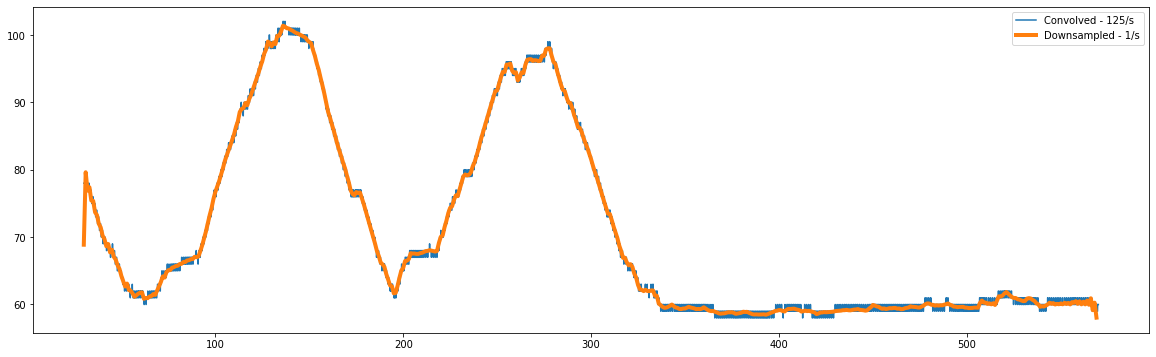

# BREATHING RATE -- Run 2

# 100-second chunks

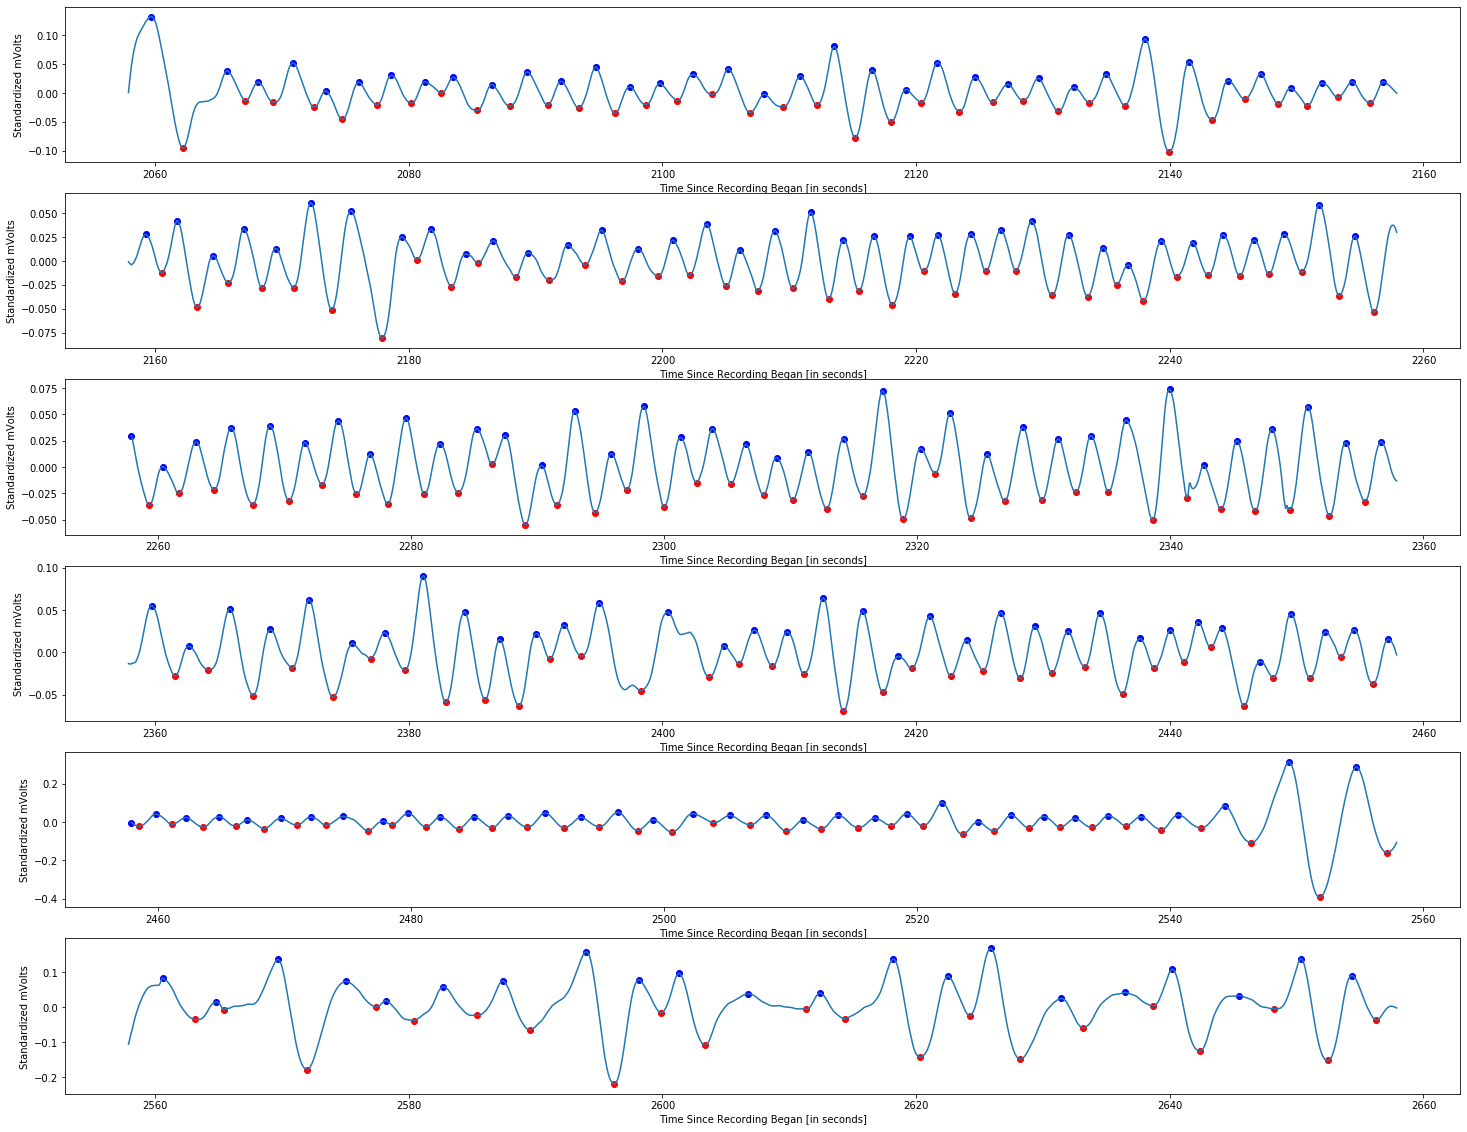

Full Run =  (200,)    Summed chunks =  (201,)


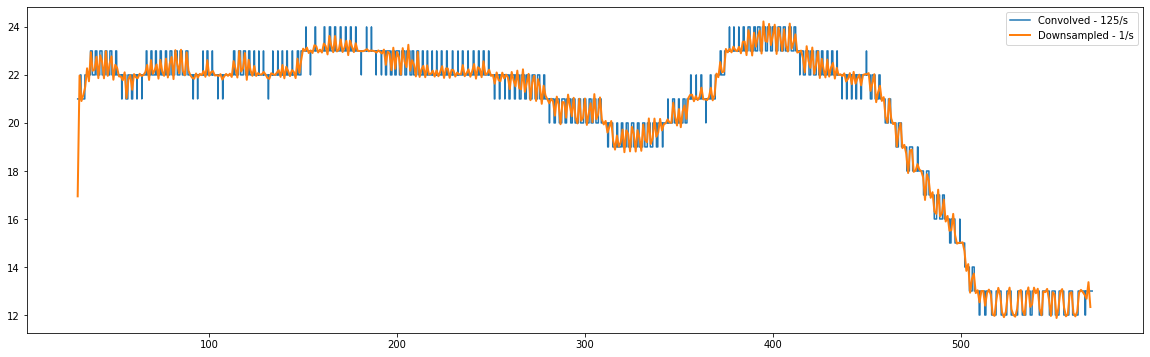

# HEART RATE -- Run 2

# 50-second chunks

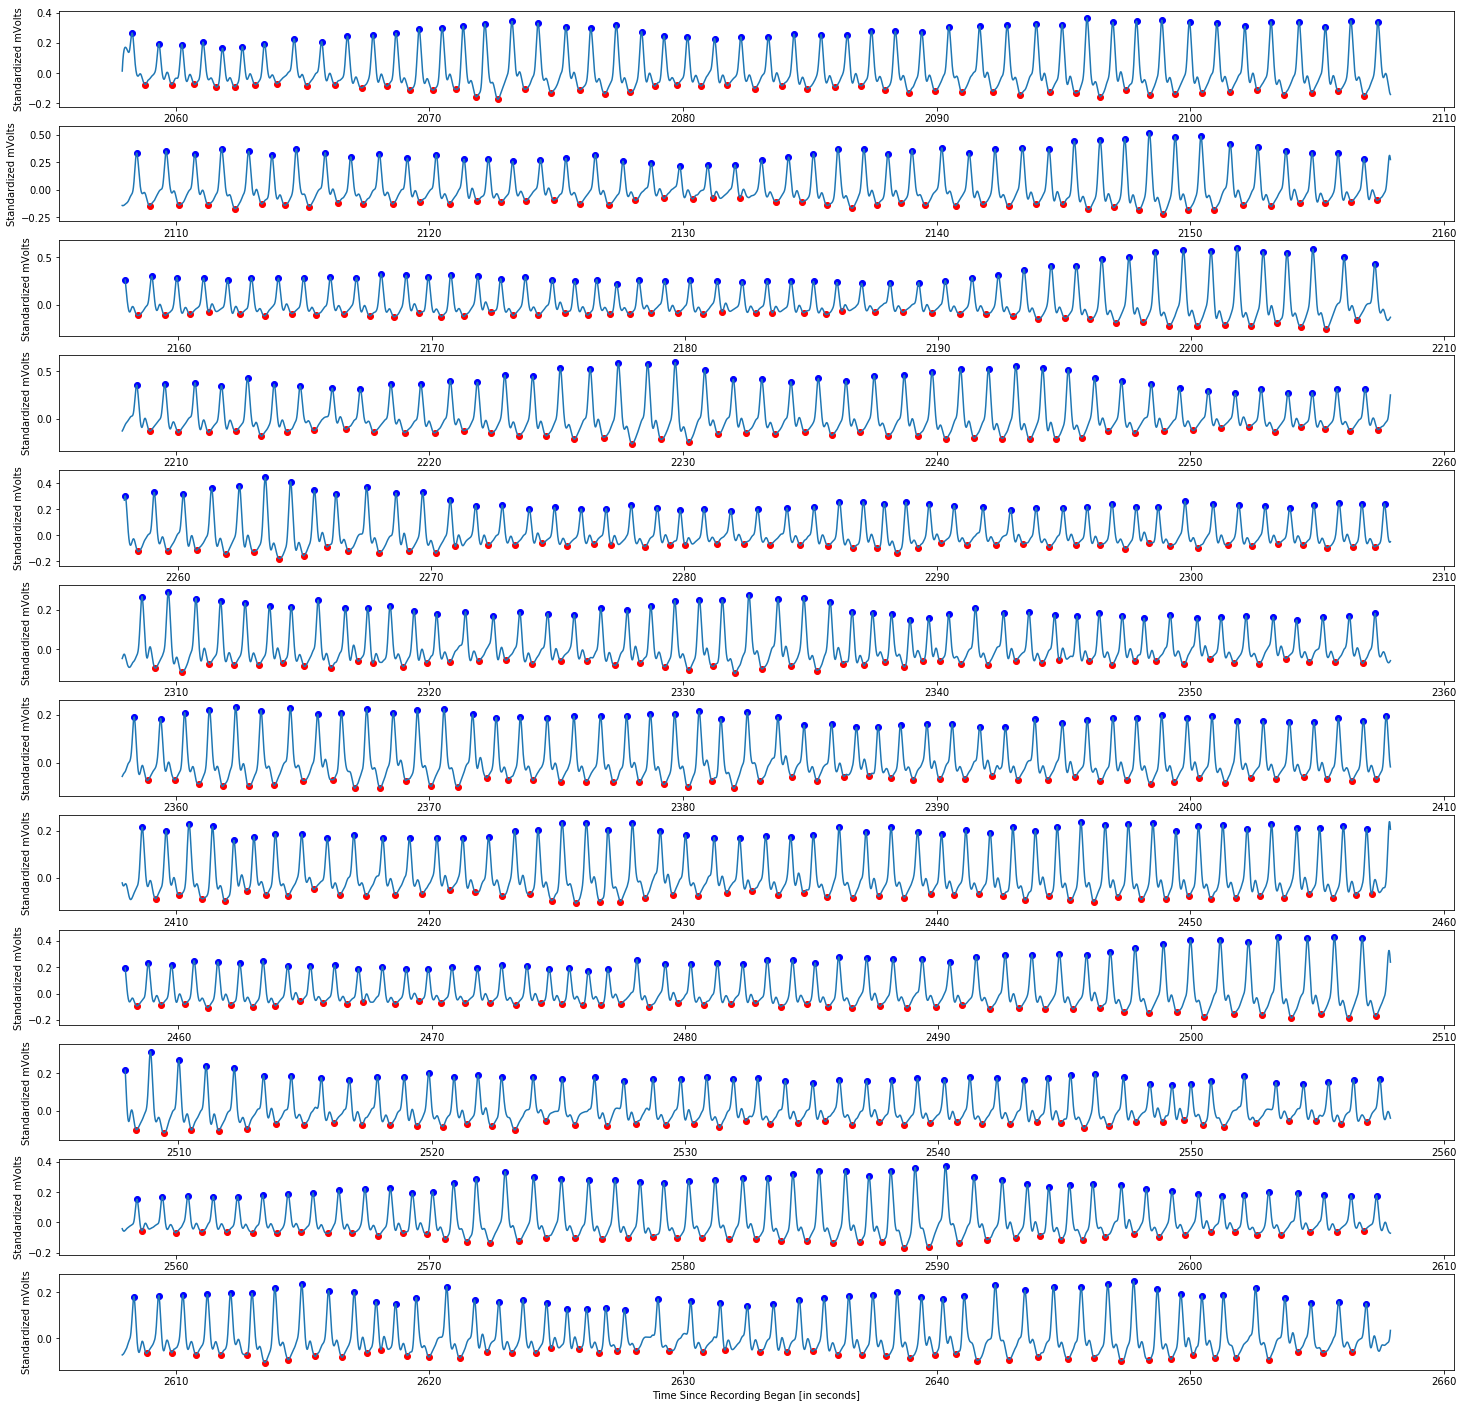

Full Run =  (592,)    Summed chunks =  (592,)


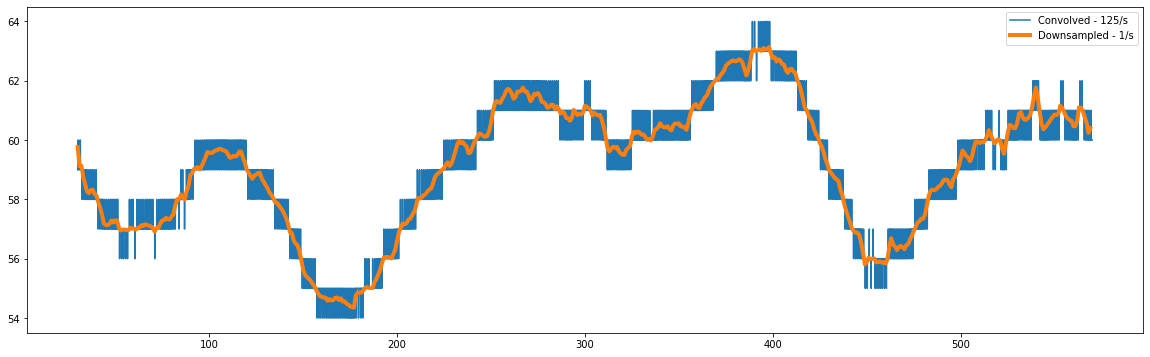

In [8]:
for run in [0,1]:
    if run == 0: 
        time = run1_BR_time
    else:
        time = run2_BR_time
    
    maxtab_BR = []
    maxtab_HR = []
    
    countArr_BR = np.zeros((nSamplesRun, 2))
    countArr_BR[:,1] = range(1,75001)
    
    countArr_HR = np.zeros((nSamplesRun, 2))
    countArr_HR[:,1] = range(1,75001)
    
    
    ### Plotting ###

    ######################
    ### BREATHING RATE ###
    ######################
    display(Markdown('# BREATHING RATE -- Run %s' %(str(run+1))))
    
    # 100 second chunks of filtered timeseries
    f, axs = plt.subplots(6, 1, figsize=(25,20))
    display(Markdown('# 100-second chunks'))
    spaces = np.linspace(0,75000,7)
    for chunk in range(6):
        indexA = int(spaces[chunk])
        indexB = int(spaces[chunk + 1])
        
        v = filtered_xBR[indexA:indexB, run]
        if run == 0:
            delta = float(np.load('%s/BreathingRate_peakDet_delta_run-001.npy' %(subpath)))
#             delta = 0.005
        else:
            delta = float(np.load('%s/BreathingRate_peakDet_delta_run-002.npy' %(subpath)))
#             delta = 0.02
        np.save('%s/BreathingRate_peakDet_delta_run-00%s.npy' %(subpath, str(run+1)), delta)#, fmt='%1.4f')
        t = time[indexA:indexB]
        [maxtab, mintab] = peakdet(v, delta, t)
        maxtab_BR = np.hstack((maxtab_BR, maxtab[:,0]))
        
        axs[chunk].plot(time[indexA:indexB], filtered_xBR[indexA:indexB, run])
        axs[chunk].scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
        axs[chunk].scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
        axs[chunk].set_ylabel('Standardized mVolts')
        axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
    plt.show()

    [maxtab_BR_all, mintab_BR_all] = peakdet(filtered_xBR[:,run], delta)
    np.savetxt('%s/BreathingRate_peakDet_PeakIdxsVals_run-00%s.txt' %(subpath, str(run+1)), maxtab_BR_all, fmt='%1.8f')
    print('Full Run = ', np.shape(maxtab_BR_all[:,0]), '   Summed chunks = ', np.shape(maxtab_BR))
    
    ### Computing and Plotting Instantaneous Rate ###
    countArr_BR[maxtab_BR_all[:,0].astype(int), 0] = 1
    
    newConv_BR = np.convolve(countArr_BR[:,0], np.ones(7500), 'valid')
    convLen_BR = np.shape(newConv_BR)[0]
    convX_BR = np.linspace(30, 570, convLen_BR, endpoint=False)
    plt.plot(convX_BR, newConv_BR)

    newSig_BR = resample(newConv_BR, 540)
    newX_BR = np.linspace(30, 570, 540, endpoint=False)
    plt.plot(newX_BR, newSig_BR, linewidth = 2)
    plt.legend(['Convolved - 125/s', 'Downsampled - 1/s'])
    plt.savefig('%s/BreathingRate_Instantaneous_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/BreathingRate_InstantaneousDownsampled_run-00%s.txt' %(subpath, str(run+1)), newSig_BR, fmt='%1.9f')
    plt.show()
    ######################
    ### Heart RATE ###
    ######################
    display(Markdown('# HEART RATE -- Run %s' %(str(run+1))))
    
    # 50 second chunks of filtered timeseries
    f, axs = plt.subplots(12, 1, figsize=(25,25))
    display(Markdown('# 50-second chunks'))
    spaces = np.linspace(0,75000,13)
    for chunk in range(12):
        indexA = int(spaces[chunk])
        indexB = int(spaces[chunk + 1])
        
        v = filtered_xHR[indexA:indexB, run]
        if run == 0:
            delta = float(np.load('%s/HeartRate_peakDet_delta_run-001.npy' %(subpath)))
#             delta = 0.1
        else:
            delta = float(np.load('%s/HeartRate_peakDet_delta_run-002.npy' %(subpath)))
#             delta = 0.125
        np.save('%s/HeartRate_peakDet_delta_run-00%s.npy' %(subpath, str(run+1)), delta)#, fmt='%1.4f')
        t = time[indexA:indexB]
        [maxtab, mintab] = peakdet(v, delta, t)
        maxtab_HR = np.hstack((maxtab_HR, maxtab[:,0]))
        
        axs[chunk].plot(time[indexA:indexB], filtered_xHR[indexA:indexB, run])
        axs[chunk].scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
        axs[chunk].scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
        axs[chunk].set_ylabel('Standardized mVolts')
        axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
    plt.show()
    [maxtab_HR_all, mintab_HR_all] = peakdet(filtered_xHR[:,run], delta)
    np.savetxt('%s/HeartRate_peakDet_PeakIdxsVals_run-00%s.txt' %(subpath, str(run+1)), maxtab_HR_all, fmt='%1.8f')
    
    print('Full Run = ', np.shape(maxtab_HR_all[:,0]), '   Summed chunks = ', np.shape(maxtab_HR))
    
    ### Computing IBI differences for computation of Root Mean Square (of) Successive Differences ###
    nBeats = np.shape(maxtab_HR_all[:,0])[0]
    rmssd_HR_IBIdiffs = np.zeros((nBeats-1)) * np.nan
    for idx, beatTime in enumerate(maxtab_HR_all[:,0].astype(int)):
        if idx == nBeats-1:
            break
        rmssd_HR_IBIdiffs[idx] = np.subtract(maxtab_HR_all[idx+1,0], maxtab_HR_all[idx,0])
    rmssd_HR_IBIdiffs = rmssd_HR_IBIdiffs * 8 #Sampling Rate is 125Hz (1/8ms), so convert values to milliseconds
    np.savetxt('%s/HeartRate_InterBeatInterval_run-00%s.txt' %(subpath, str(run+1)), rmssd_HR_IBIdiffs, fmt='%i')

    ### Computing and Plotting Instantaneous Rate ###
    countArr_HR[maxtab_HR_all[:,0].astype(int), 0] = 1
    
    newConv_HR = np.convolve(countArr_HR[:,0], np.ones(7500), 'valid')
    convLen_HR = np.shape(newConv_HR)[0]
    convX_HR = np.linspace(30, 570, convLen_HR, endpoint=False)
    plt.plot(convX_HR, newConv_HR)

    newSig_HR = resample(newConv_HR, 540)
    newX_HR = np.linspace(30, 570, 540, endpoint=False)
    plt.plot(newX_HR, newSig_HR, linewidth = 4)
    plt.legend(['Convolved - 125/s', 'Downsampled - 1/s'])
    plt.savefig('%s/HeartRate_Instantaneous_run-00%s.pdf' %(subpath, str(run+1)))
    np.savetxt('%s/HeartRate_InstantaneousDownsampled_run-00%s.txt' %(subpath, str(run+1)), newSig_HR, fmt='%1.9f')
    plt.show()
    

In [ ]:
####################################################################################################
### The code below is for subjects who have atypical data due to physio recording device failure ###
####################################################################################################

In [ ]:
# # This is going to be a loop that takes in the raw physio data, isolates each epi run, 
# # standardizes the run (scales value to be between 0 - 1), and then bandpass filters it
# sublist = ['088']
# for sidx, sub in enumerate(sublist):
    
#     subpath = '%s/%s' %(physPath, sub)
#     fname = os.listdir('%s/%s/' %(physPath, sub))[0]
#     fullpath = '%s/%s' %(subpath, fname)
    
#     print(fullpath)
#     data = bioread.read_file('%s' %(fullpath))
    
#     HR_arr = np.ones((nSamplesRun))
#     BR_arr = np.ones((nSamplesRun))
    
#     HR_arr_scl = np.ones((nSamplesRun))
#     BR_arr_scl = np.ones((nSamplesRun))
    
#     filtered_xHR = np.ones((nSamplesRun))
#     filtered_xBR = np.ones((nSamplesRun))
        
#     HR_chan = data.channels[0]
#     BR_chan = data.channels[2]
#     TTL_chan = data.channels[3]

#     # Find the time point when the very first TTL signal comes in (usually 8 ± 1 in duration of 1 TTL)
#     TTL_startR1 = np.where(TTL_chan.data>4)[0][0]

#     # Isolate all the data that occurs AFTER Run 1 ends
# #     run2_TTL_data_pre = TTL_chan.data[TTL_startR1 + nSamplesRun:]
   
#     # Now determine when the first TTL comes in in this new chunk
# #     TTL_startR2 = np.where(run2_TTL_data_pre>4)[0][0]

#     # The chunk of data for Run 1 (of 2) should be the first TTL sample + nSamplesRun [75000]
#     run1_HR_data = HR_chan.data[TTL_startR1:TTL_startR1 + nSamplesRun]
#     run1_HR_time = HR_chan.time_index[TTL_startR1:TTL_startR1 + nSamplesRun]

#     run1_BR_data = BR_chan.data[TTL_startR1:TTL_startR1 + nSamplesRun]
#     run1_BR_time = BR_chan.time_index[TTL_startR1:TTL_startR1 + nSamplesRun]

#     # First step will be to isolate all the data that occurs AFTER Run 1's chunk ends
# #     run2_HR_data_pre = HR_chan.data[TTL_startR1 + nSamplesRun:]
# #     run2_HR_time_pre = HR_chan.time_index[TTL_startR1 + nSamplesRun:]

# #     run2_BR_data_pre = BR_chan.data[TTL_startR1 + nSamplesRun:]
# #     run2_BR_time_pre = BR_chan.time_index[TTL_startR1 + nSamplesRun:]

#     # Isolate the run the 10 minutes that occur after the first TTL pulse
# #     run2_HR_data = run2_HR_data_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
# #     run2_HR_time = run2_HR_time_pre[TTL_startR2:TTL_startR2 + nSamplesRun]

# #     run2_BR_data = run2_BR_data_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
# #     run2_BR_time = run2_BR_time_pre[TTL_startR2:TTL_startR2 + nSamplesRun]
    
#     HR_arr = run1_HR_data
#     BR_arr = run1_BR_data
    
#     ### With the data isolated, now we need to standardize the raw, isolated traces
#     for run in [0]:
#         print(run)
#         xMinHR = np.min(HR_arr)
#         xMaxHR = np.max(HR_arr)

#         xMinBR = np.min(BR_arr)
#         xMaxBR = np.max(BR_arr)

#         newDataHR = [ [np.divide([x-xMinHR], [xMaxHR - xMinHR])] for x in HR_arr]
#         HR_arr_scl = np.squeeze(newDataHR)
        
#         newDataBR = [ [np.divide([x-xMinBR], [xMaxBR - xMinBR])] for x in BR_arr]
#         BR_arr_scl = np.squeeze(newDataBR)
        
#         ### Filter the data ###

#         # Breathing Rate #
#         freqLow_BR = 0.25
#         freqHigh_BR = 0.50
#         windowBR = np.divide([freqLow_BR, freqHigh_BR], sampRate)
#         bBR, aBR = butter(1, windowBR, 'bandpass')
#         xBR = BR_arr_scl
#         filtered_xBR = lfilter(bBR, aBR, xBR)
        
#         # Heart Rate #
#         freqLow_HR = 1
#         freqHigh_HR = 6
#         windowHR = np.divide([freqLow_HR, freqHigh_HR], sampRate)
#         bHR,aHR = butter(1, windowHR, 'bandpass')
#         xHR = HR_arr_scl
#         filtered_xHR = lfilter(bHR, aHR, xHR)

In [ ]:
# for run in [0]:
#     if run == 0: 
#         time = run1_BR_time #Doesn't matter if BR or HR time. It's the same thing

#     ### Plotting ###

#     ######################
#     ### BREATHING RATE ###
#     ######################
#     display(Markdown('# BREATHING RATE -- Run %s' %(str(run+1))))
    
#     # Raw TimeSeries (all data)
#     display(Markdown('# Raw TimeSeries'))
#     plt.plot(time, BR_arr)
#     plt.ylabel('mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.savefig('%s/BreathingRate_RawTS_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/BreathingRate_RawTS_run-00%s.txt' %(subpath, str(run+1)), BR_arr, fmt='%1.9f')
#     plt.show()

#     # Standardized TimeSeries
#     display(Markdown('# Standardized TimeSeries'))
#     plt.plot(time, BR_arr_scl)
#     plt.ylabel('Standardized mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.show()

#     # Filtered TimeSeries
#     display(Markdown('# Filtered TimeSeries'))
#     plt.plot(time, filtered_xBR)
#     plt.ylabel('Standardized mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.savefig('%s/BreathingRate_FilteredTS_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/BreathingRate_FilteredTS_run-00%s.txt' %(subpath, str(run+1)), filtered_xBR, fmt='%1.9f') 
#     plt.show()

#     # 100 second chunks of filtered timeseries
#     f, axs = plt.subplots(6, 1, figsize=(25,20))
#     display(Markdown('# 100-second chunks'))
#     spaces = np.linspace(0,75000,7)
#     for chunk in range(6):
#         indexA = int(spaces[chunk])
#         indexB = int(spaces[chunk + 1])
#         axs[chunk].plot(time[indexA:indexB], filtered_xBR[indexA:indexB])
#         axs[chunk].set_ylabel('Standardized mVolts')
#         axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
#     plt.show()

#     # Power Spectrum Plot (Raw vs. Filtered)
#     display(Markdown('# Power Plot'))
#     f, Pxx_den = periodogram(BR_arr, 125)
#     fFilt, Pxx_denFilt = periodogram(filtered_xBR, 125)
#     plt.semilogy(f, Pxx_den)
#     plt.semilogy(fFilt, Pxx_denFilt)
#     plt.ylim([1e-10, 1e2])
#     plt.xlim([0,6])
#     plt.xlabel('frequency [Hz]')
#     plt.ylabel('PSD [V**2/Hz]')
#     plt.legend(['Raw', 'Filtered'])
#     plt.savefig('%s/BreathingRate_PowerPlot_run-00%s.pdf' %(subpath, str(run+1)))
#     plt.show()
    
    
    
#     ######################
#     ### Heart RATE ###
#     ######################
    
#     display(Markdown('# HEART RATE -- Run %s' %(str(run+1))))
    
#     # Raw TimeSeries (all data)
#     display(Markdown('# Raw TimeSeries'))
#     plt.plot(time, HR_arr)
#     plt.ylabel('mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.savefig('%s/HeartRate_RawTS_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/HeartRate_RawTS_run-00%s.txt' %(subpath, str(run+1)), HR_arr, fmt='%1.9f')
#     plt.show()

#     # Standardized TimeSeries
#     display(Markdown('# Standardized TimeSeries'))
#     plt.plot(time, HR_arr_scl)
#     plt.ylabel('Standardized mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.show()

#     # Filtered TimeSeries
#     display(Markdown('# Filtered TimeSeries'))
#     plt.plot(time, filtered_xHR)
#     plt.ylabel('Standardized mVolts')
#     plt.xlabel('Time Since Recording Began [in seconds]')
#     plt.savefig('%s/HeartRate_FilteredTS_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/HeartRate_FilteredTS_run-00%s.txt' %(subpath, str(run+1)), filtered_xHR, fmt='%1.9f') 
#     plt.show()

#     # 100 second chunks of filtered timeseries
#     f, axs = plt.subplots(12, 1, figsize=(25,25))
#     display(Markdown('# 50-second chunks'))
#     spaces = np.linspace(0,75000,13)
#     for chunk in range(12):
#         indexA = int(spaces[chunk])
#         indexB = int(spaces[chunk + 1])
#         axs[chunk].plot(time[indexA:indexB], filtered_xHR[indexA:indexB])
#         axs[chunk].set_ylabel('Standardized mVolts')
#         axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
#     plt.show()

#     # Power Spectrum Plot (Raw vs. Filtered)
#     display(Markdown('# Power Plot'))
#     f, Pxx_den = periodogram(HR_arr, 125)
#     fFilt, Pxx_denFilt = periodogram(filtered_xHR, 125)
#     plt.semilogy(f, Pxx_den)
#     plt.semilogy(fFilt, Pxx_denFilt)
#     plt.ylim([1e-10, 1e2])
#     plt.xlim([0,20])
#     plt.xlabel('frequency [Hz]')
#     plt.ylabel('PSD [V**2/Hz]')
#     plt.legend(['Raw', 'Filtered'])
#     plt.savefig('%s/HeartRate_PowerPlot_run-00%s.pdf' %(subpath, str(run+1)))
#     plt.show()

In [ ]:
# for run in [0]:
#     if run == 0: 
#         time = run1_BR_time
    
#     maxtab_BR = []
#     maxtab_HR = []
    
#     countArr_BR = np.zeros((nSamplesRun, 2))
#     countArr_BR[:,1] = range(1,75001)
    
#     countArr_HR = np.zeros((nSamplesRun, 2))
#     countArr_HR[:,1] = range(1,75001)
    
#     ### Plotting ###

#     ######################
#     ### BREATHING RATE ###
#     ######################
#     display(Markdown('# BREATHING RATE -- Run %s' %(str(run+1))))
    
#     # 100 second chunks of filtered timeseries
#     f, axs = plt.subplots(6, 1, figsize=(25,20))
#     display(Markdown('# 100-second chunks'))
#     spaces = np.linspace(0,75000,7)
#     for chunk in range(6):
#         indexA = int(spaces[chunk])
#         indexB = int(spaces[chunk + 1])
        
#         v = filtered_xBR[indexA:indexB]
#         if run == 0:
#             delta = float(np.load('%s/BreathingRate_peakDet_delta_run-001.npy' %(subpath)))
# #             delta = 0.01
# #         else:
# #             delta = 0.01
#         np.save('%s/BreathingRate_peakDet_delta_run-00%s.npy' %(subpath, str(run+1)), delta)#, fmt='%1.4f')
#         t = time[indexA:indexB]
#         [maxtab, mintab] = peakdet(v, delta, t)
#         maxtab_BR = np.hstack((maxtab_BR, maxtab[:,0]))
        
#         axs[chunk].plot(time[indexA:indexB], filtered_xBR[indexA:indexB])
#         axs[chunk].scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
#         axs[chunk].scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
#         axs[chunk].set_ylabel('Standardized mVolts')
#         axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
#     plt.show()

#     [maxtab_BR_all, mintab_BR_all] = peakdet(filtered_xBR[:], delta)
#     np.savetxt('%s/BreathingRate_peakDet_PeakIdxsVals_run-00%s.txt' %(subpath, str(run+1)), maxtab_BR_all, fmt='%1.8f')
#     print('Full Run = ', np.shape(maxtab_BR_all[:,0]), '   Summed chunks = ', np.shape(maxtab_BR))
    
#     ### Computing and Plotting Instantaneous Rate ###
#     countArr_BR[maxtab_BR_all[:,0].astype(int), 0] = 1
    
#     newConv_BR = np.convolve(countArr_BR[:,0], np.ones(7500), 'valid')
#     convLen_BR = np.shape(newConv_BR)[0]
#     convX_BR = np.linspace(30, 570, convLen_BR, endpoint=False)
#     plt.plot(convX_BR, newConv_BR)

#     newSig_BR = resample(newConv_BR, 540)
#     newX_BR = np.linspace(30, 570, 540, endpoint=False)
#     plt.plot(newX_BR, newSig_BR, linewidth = 2)
#     plt.legend(['Convolved - 125/s', 'Downsampled - 1/s'])
#     plt.savefig('%s/BreathingRate_Instantaneous_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/BreathingRate_InstantaneousDownsampled_run-00%s.txt' %(subpath, str(run+1)), newSig_BR, fmt='%1.9f')
#     plt.show()
#     ######################
#     ### Heart RATE ###
#     ######################
#     display(Markdown('# HEART RATE -- Run %s' %(str(run+1))))
    
#     # 50 second chunks of filtered timeseries
#     f, axs = plt.subplots(12, 1, figsize=(25,25))
#     display(Markdown('# 50-second chunks'))
#     spaces = np.linspace(0,75000,13)
#     for chunk in range(12):
#         indexA = int(spaces[chunk])
#         indexB = int(spaces[chunk + 1])
        
#         v = filtered_xHR[indexA:indexB]
#         if run == 0:
#             delta = float(np.load('%s/HeartRate_peakDet_delta_run-001.npy' %(subpath)))
# #             delta = 0.15
# #         else:
# #             delta = 0.1
#         np.save('%s/HeartRate_peakDet_delta_run-00%s.npy' %(subpath, str(run+1)), delta)#, fmt='%1.4f')
#         t = time[indexA:indexB]
#         [maxtab, mintab] = peakdet(v, delta, t)
#         maxtab_HR = np.hstack((maxtab_HR, maxtab[:,0]))
        
#         axs[chunk].plot(time[indexA:indexB], filtered_xHR[indexA:indexB])
#         axs[chunk].scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
#         axs[chunk].scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')
#         axs[chunk].set_ylabel('Standardized mVolts')
#         axs[chunk].set_xlabel('Time Since Recording Began [in seconds]')
#     plt.show()
#     [maxtab_HR_all, mintab_HR_all] = peakdet(filtered_xHR[:], delta)
#     np.savetxt('%s/HeartRate_peakDet_PeakIdxsVals_run-00%s.txt' %(subpath, str(run+1)), maxtab_HR_all, fmt='%1.8f')

#     print('Full Run = ', np.shape(maxtab_HR_all[:,0]), '   Summed chunks = ', np.shape(maxtab_HR))
    
#     ### Computing Root Mean Square (of) Successive Differences ###
#     nBeats = np.shape(maxtab_HR_all[:,0])[0]
#     rmssd_HR_IBIdiffs = np.zeros((nBeats-1)) * np.nan
#     for idx, beatTime in enumerate(maxtab_HR_all[:,0].astype(int)):
#         if idx == nBeats-1:
#             break
#         rmssd_HR_IBIdiffs[idx] = np.subtract(maxtab_HR_all[idx+1,0], maxtab_HR_all[idx,0])
#     rmssd_HR_IBIdiffs = rmssd_HR_IBIdiffs * 8 #Sampling Rate is 125Hz (1/8ms), so convert values to milliseconds
#     np.savetxt('%s/HeartRate_InterBeatInterval_run-00%s.txt' %(subpath, str(run+1)), rmssd_HR_IBIdiffs, fmt='%i')

    
#     ### Computing and Plotting Instantaneous Rate ###
#     countArr_HR[maxtab_HR_all[:,0].astype(int), 0] = 1
    
#     newConv_HR = np.convolve(countArr_HR[:,0], np.ones(7500), 'valid')
#     convLen_HR = np.shape(newConv_HR)[0]
#     convX_HR = np.linspace(30, 570, convLen_HR, endpoint=False)
#     plt.plot(convX_HR, newConv_HR)

#     newSig_HR = resample(newConv_HR, 540)
#     newX_HR = np.linspace(30, 570, 540, endpoint=False)
#     plt.plot(newX_HR, newSig_HR, linewidth = 4)
#     plt.legend(['Convolved - 125/s', 'Downsampled - 1/s'])
#     plt.savefig('%s/HeartRate_Instantaneous_run-00%s.pdf' %(subpath, str(run+1)))
#     np.savetxt('%s/HeartRate_InstantaneousDownsampled_run-00%s.txt' %(subpath, str(run+1)), newSig_HR, fmt='%1.9f')
#     plt.show()